In [2]:
%%capture
# 필요한 패키지 일괄 설치 (코랩 등 환경에서 실행 시)
!pip install -q crewai==0.36.0 pandas>=2.0.0 openai>=1.0.0 langchain

# Step 1: Data Preprocessing for AI Vet Consultant

이 노트북에서는 AI 수의사 상담 시스템을 위한 데이터를 준비합니다.
CSV 파일에 있는 반려동물의 증상과 정보를 AI 모델이 이해하기 쉬운 **프롬프트 형식**으로 변환하는 과정을 실습합니다.

In [3]:
import pandas as pd
import os

# 데이터 경로 설정 (더 큰 데이터셋 사용)
INPUT_CSV_PATH = "../00_datasets/dr.tail/Dr.tail_210.CSV"
OUTPUT_DIR = "./data"

# 출력 디렉토리 생성
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created directory: {OUTPUT_DIR}")

In [4]:
import requests
import os

# User provided URL for processed_sample.csv
DOWNLOAD_URL = "https://raw.githubusercontent.com/pon07029/04_student_exercise/main/data/processed_sample.csv"
OUTPUT_DIR = "./data"
OUTPUT_FILENAME = "processed_sample.csv"

# Ensure output directory exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

try:
    response = requests.get(DOWNLOAD_URL)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

    with open(output_path, "wb") as f:
        f.write(response.content)
    print(f"Successfully downloaded and saved {OUTPUT_FILENAME} to {output_path}")
except requests.exceptions.RequestException as e:
    print(f"Error downloading file from {DOWNLOAD_URL}: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully downloaded and saved processed_sample.csv to ./data/processed_sample.csv


## Downloaded `processed_sample.csv` from User-Provided URL

위에서 생성된 `processed_sample.csv` 파일 대신, 사용자가 제공한 URL에서 최신 `processed_sample.csv` 파일을 다운로드하여 사용합니다. 이 파일은 이후의 모든 에이전트 작업 및 평가 단계에서 활용됩니다.

## 1. 데이터 로드 및 확인
Pandas를 사용하여 CSV 파일을 읽고 데이터 구조를 확인합니다. 실습을 위해 5개만 샘플링합니다.

In [5]:
try:
    df_raw = pd.read_csv(output_path)
    df = df_raw.head(5).copy()
    print(f"Successfully loaded dataset. Using first {len(df)} cases for exercise.")
    display(df.head(2))
except FileNotFoundError:
    print(f"Error: File not found at {INPUT_CSV_PATH}")

Successfully loaded dataset. Using first 5 cases for exercise.


,formatted_prompt,answer
0,Symptom:\nDiarrhea\n\nPet Information:\nName\n...,The symptoms you're describing in your Portugu...
1,Symptom:\nDiarrhea\n\nPet Information:\nName\n...,Diarrhea in a 3-month-old Pyrenean Shepherd pu...


## 2. 프롬프트 포맷팅 함수 작성 (실습)
각 행(Row)의 정보를 하나의 완성된 질문(Prompt) 텍스트로 합치는 함수를 작성해 봅시다.

**목표 형식:**
```
증상 (Symptom):
[증상 내용]

반려동물 정보 (Pet Information):
[반려동물 정보]

상세 문제 (Issue Details):
[상세 문제]

보호자 추가 설명 (More Details from Guardian):
[보호자 추가 설명]
```

In [6]:
def format_input_from_row(row):
    """Pandas 데이터프레임의 한 행을 받아 AI 입력 형식 문자열로 변환합니다."""

    # 1. 데이터 추출 (없는 경우 빈 문자열 처리)
    symptom = str(row.get('symptom', ''))
    pet_info = str(row.get('pet_information', ''))
    issue_details = str(row.get('issue_details', ''))
    more_details = str(row.get('more_details', ''))

    # 2. 포맷팅 (여기에 코드를 작성하세요)
    full_description = f"""
증상 (Symptom):
{symptom}

반려동물 정보 (Pet Information):
{pet_info}

상세 문제 (Issue Details):
{issue_details}

보호자 추가 설명 (More Details from Guardian):
{more_details}
"""
    return full_description.strip()

# 테스트: 첫 번째 행으로 결과 확인
if not df.empty:
    sample_row = df.iloc[0]
    print(format_input_from_row(sample_row))

증상 (Symptom):


반려동물 정보 (Pet Information):


상세 문제 (Issue Details):


보호자 추가 설명 (More Details from Guardian):


## 3. 전체 데이터 변환 및 저장
모든 데이터에 이 함수를 적용하고, 나중에 사용할 수 있도록 저장합니다.

In [7]:
# 새로운 컬럼 'formatted_prompt' 생성
df['formatted_prompt'] = df.apply(format_input_from_row, axis=1)

# 필요한 컬럼만 선택하여 저장 (Prompt와 정답 Answer)
df_processed = df[['formatted_prompt', 'answer']]

output_path = os.path.join(OUTPUT_DIR, "processed_sample.csv")
df_processed.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"Saved {len(df_processed)} processed cases to {output_path}")
display(df_processed.head(1))

Saved 5 processed cases to ./data/processed_sample.csv


,formatted_prompt,answer
0,증상 (Symptom):\n\n\n반려동물 정보 (Pet Information):\...,The symptoms you're describing in your Portugu...


# Step 2: Single Agent Consultation

이 단계에서는 CrewAI의 가장 기본적인 단위인 **Single Agent(단일 에이전트)**를 만들어 봅니다.
복잡한 도구 없이, LLM의 지식만으로 반려동물의 증상을 분석하고 조언을 제공하는 '종합 수의사' 에이전트를 구현합니다.

In [8]:
# 필요한 라이브러리 설치 (최초 1회 실행)
try:
    import crewai
except ImportError:
    print("Installing crewai and dependencies...")
    !pip install crewai pandas openai

import os
import pandas as pd
from crewai import Agent, Task, Crew, LLM

# 환경 변수 설정 (API 키 하드코딩)
os.environ["OPENAI_API_KEY"] = "ENTER THE API KEY"
os.environ["OPENAI_MODEL_NAME"] = "gpt-5-mini" # 기본 모델 설정


## 1. LLM 설정
에이전트가 사용할 두뇌(LLM)를 설정합니다. 여기서는 gpt-5-mini를 사용합니다.

In [9]:
# LLM 설정
my_llm = LLM(
    model="gpt-5-mini",
    temperature=1
)

## 2. Agent 정의 (실습)
**`Agent`**는 특정 역할을 수행하는 AI 직원입니다.
- **Role**: 직책 (예: Pet Health Consultant)
- **Goal**: 목표 (예: 증상을 분석하여 조언 제공)
- **Backstory**: 배경 설정 (예: 10년 경력의 수의사...)

In [11]:
pet_consultant = Agent(
    role="종합 반려동물 건강 컨설턴트",
    goal="""
        보호자가 제공한 반려동물의 증상을 분석하고 종합적인 수의학 상담을 제공합니다.
        긴급도를 평가하고, 예상되는 원인을 제시하며, 실질적인 조언을 한국어로 작성합니다.
    """,
    backstory="""
        당신은 따뜻한 마음을 가진 경험 풍부한 수의사입니다.
        걱정하는 반려인들을 위해 복잡한 의학적 문제를 알기 쉬운 말로 설명하는 데 탁월한 능력을 갖추고 있습니다.
        당신은 항상 동물의 안전과 웰빙을 최우선으로 생각합니다.
    """,
    llm=my_llm,
    verbose=True
)

## 3. Task 정의 (실습)
**`Task`**는 에이전트가 수행해야 할 구체적인 작업입니다.
- **Description**: 작업 내용 (구체적으로 작성)
- **Expected Output**: 결과물의 형식

In [12]:
consultation_task = Task(
    description="""
        다음 반려동물 건강 케이스를 분석하세요:
        <case>
        {case_input}
        </case>

        당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:
        1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)
        2. 예상되는 원인 (감별 진단)
        3. 보호자를 위한 향후 권장 조치 및 조언
    """,
    expected_output="""
        마크다운 형식으로 작성된 전문적인 수의학 상담 리포트.
        '긴급도', '예상 원인', '권장 조치' 섹션을 포함해야 하며, 모든 내용은 한국어로 작성되어야 합니다.
    """,
    agent=pet_consultant
)

## 4. Crew 실행 (반복)
Agent와 Task를 하나로 묶어 **`Crew`**를 만들고 실행합니다.
Step 1에서 만든 5개의 데이터를 순회하며 모두 실행해 봅니다.

In [13]:
# 1. 데이터 로드
df_processed = pd.read_csv("./data/processed_sample.csv")
print(f"Loaded {len(df_processed)} cases.")

# 2. Crew 생성
single_agent_crew = Crew(
    agents=[pet_consultant],
    tasks=[consultation_task],
    verbose=True
)

# 3. 반복 실행 및 저장
outputs = []
for i, row in df_processed.iterrows():
    print(f"\n--- Processing Case #{i+1} ---")
    case_input = row['formatted_prompt']

    result = single_agent_crew.kickoff(inputs={"case_input": case_input})
    outputs.append(result.raw)

    # 개별 결과 저장
    with open(f"./data/single_result_{i}.md", "w", encoding="utf-8") as f:
        f.write(result.raw)

print("\nAll cases processed.")

Loaded 5 cases.

--- Processing Case #1 ---


╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  ID: 5df5d874-03df-4fe3-ac6b-6ac8cf07be23                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Task:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # 종합 수의학 상담 리포트                                                                                      │
│                                                                                                                 │
│  현재 제공된 케이스 정보에는 증상·반려동물 정보·상세 문제·보호자 설명이 모두 비어 있어 직접적인 진단이나        │
│  확정적 판단을 내릴 수 없습니다. 아래는 정보가 부족한 상황에서 보호자님께 즉시 도움이 되는 일반적 평가 기준,    │
│  가능한 원인(감별진단), 그리고 당장 취해야 할 실질적 권장 조치입니다. 가능한 한 빨리 아래 질문들에 답해 주시면  │
│  보다 구체적이고 맞춤형 상담을 드리겠습니다.                                                                    │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│  (명확한 증상·상태를 알려주시면 정확한 긴급도 분류 가능)                                                        │
│                                                                                                                 │
│  아래 증상 중 하나라도 해당되면 즉시 응급 처치 및 응급동물병원 방문이 필요합니다(분류: 위급 또는 응급).         │
│                                                                                                                 │
│  - 위급 (즉시 응급실로 이동)                                                                                    │
│    - 호흡곤란, 질식(숨을 잘 못 쉼), 의식 소실·혼수, 심한 출혈(멈추지 않음), 심한 경련(발작이 계속되거나 5분     │
│  이상), 급격한 폐색(질식/저체온 포함), 심한 외상(차에 치임·떨어짐 등)                                           │
│    - 혀·잇몸이 창백하거나 푸르스름함(저산소), 체온이 매우 낮거나 매우 높음(고열·열사병)                         │
│    - 지속적 구토·설사로 인해 탈수 상태, 혈변·검은 변                                                            │
│    - 중독(특히 자일리톨·초콜릿·살충제·항응애제 노출 의심) — 즉시 독극물센터 또는 응급수의사와 상담              │
│                                                                                                                 │
│  - 응급 (빠른 시간 내 수의사 방문 권장, 몇 시간 이내)                                                           │
│    - 반복적 구토·설사, 지속적 식욕부진(하루 이상), 심한 통증으로 보이는 행동(짖음·울음·움직이지 않음), 다리에   │
│  힘이 빠짐·절뚝임이 심해짐, 소변을 못 봄(배뇨곤란)                                                              │
│    - 눈의 심한 충혈·눈물·반점, 귀의 심한 냄새·분비물                                                            │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토·일시적 무기력, 식욕 감소(12–24시간), 가벼운 피부발적·가려움                                    │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 단회성 가벼운 설사·가벼운 가려움·일시적 기운 없음(단, 악화되면 재평가)                                     │
│                                                                                                                 │
│  ※ 현재 반려동물의 상태가 어떤지(호흡, 의식, 출혈, 구토·설사 유무, 활동성, 먹고 마시는지 등)를 알려주시면 즉시  │
│  긴급도를 판정해 드립니다.                                                                                      │
│          

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│                                                                                                                 │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  종합 반려동물 건강 컨설턴트                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│  Final Output: # 종합 수의학 상담 리포트                                                                        │
│                                                                                                                 │
│  현재 제공된 케이스 정보에는 증상·반려동물 정보·상세 문제·보호자 설명이 모두 비어 있어 직접적인 진단이나        │
│  확정적 판단을 내릴 수 없습니다. 아래는 정보가 부족한 상황에서 보호자님께 즉시 도움이 되는 일반적 평가 기준,    │
│  가능한 원인(감별진단), 그리고 당장 취해야 할 실질적 권장 조치입니다. 가능한 한 빨리 아래 질문들에 답해 주시면  │
│  보다 구체적이고 맞춤형 상담을 드리겠습니다.                                                                    │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│  (명확한 증상·상태를 알려주시면 정확한 긴급도 분류 가능)                                                        │
│                                                                                                                 │
│  아래 증상 중 하나라도 해당되면 즉시 응급 처치 및 응급동물병원 방문이 필요합니다(분류: 위급 또는 응급).         │
│                                                                                                                 │
│  - 위급 (즉시 응급실로 이동)                                                                                    │
│    - 호흡곤란, 질식(숨을 잘 못 쉼), 의식 소실·혼수, 심한 출혈(멈추지 않음), 심한 경련(발작이 계속되거나 5분     │
│  이상), 급격한 폐색(질식/저체온 포함), 심한 외상(차에 치임·떨어짐 등)                                           │
│    - 혀·잇몸이 창백하거나 푸르스름함(저산소), 체온이 매우 낮거나 매우 높음(고열·열사병)                         │
│    - 지속적 구토·설사로 인해 탈수 상태, 혈변·검은 변                                                            │
│    - 중독(특히 자일리톨·초콜릿·살충제·항응애제 노출 의심) — 즉시 독극물센터 또는 응급수의사와 상담              │
│                                                                                                                 │
│  - 응급 (빠른 시간 내 수의사 방문 권장, 몇 시간 이내)                                                           │
│    - 반복적 구토·설사, 지속적 식욕부진(하루 이상), 심한 통증으로 보이는 행동(짖음·울음·움직이지 않음), 다리에   │
│  힘이 빠짐·절뚝임이 심해짐, 소변을 못 봄(배뇨곤란)                                                              │
│    - 눈의 심한 충혈·눈물·반점, 귀의 심한 냄새·분비물                                                            │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토·일시적 무기력, 식욕 감소(12–24시간), 가벼운 피부발적·가려움                                    │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 단회성 가벼운 설사·가벼운 가려움·일시적 기운 없음(단, 악화되면 재평가)                                     │
│                                                           


--- Processing Case #2 ---


╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  ID: 5df5d874-03df-4fe3-ac6b-6ac8cf07be23                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Task:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # 종합 수의학 상담 리포트                                                                                      │
│                                                                                                                 │
│  현재 제출된 케이스에서는 증상·반려동물 정보·상세 문제·보호자 설명이 모두 비어 있어 정확한 진단이나 확정적      │
│  긴급도 판정을 할 수 없습니다.                                                                                  │
│  아래는 정보가 부족한 상태에서 보호자님께 즉시 도움이 되는 일반적 평가 기준, 가능한 원인(감별진단) 및 실질적    │
│  권장 조치입니다. 가능한 한 빨리 아래 질문들에 답해 주시면 보다 구체적이고 맞춤형 상담을 드리겠습니다.          │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│                                                                                                                 │
│  아래 증상 중 하나라도 해당되면 즉시 응급 동물병원 방문(위급 또는 응급) 권장합니다.                             │
│                                                                                                                 │
│  - 위급 (즉시 응급실로 이동)                                                                                    │
│    - 호흡곤란(숨을 잘 못 쉬거나 숨소리가 매우 거칠고 급함), 의식 소실·혼수                                      │
│    - 심한 출혈(지혈해도 멈추지 않음)                                                                            │
│    - 발작이 5분 이상 지속되거나 반복적 발작                                                                     │
│    - 급격한 약화로 걷지 못함, 전신 마비 의심                                                                    │
│    - 심한 외상(교통사고, 높은 곳에서 추락 등)                                                                   │
│    - 중독이 확실하거나 의심되는 경우(특히 자일리톨, 초콜릿, 살충제 등)                                          │
│    - 지속적 구토·설사로 인한 탈수와 전해질 이상, 혈변 또는 검은색 변                                            │
│                                                                                                                 │
│  - 응급 (몇 시간 이내 수의사 방문 권장)                                                                         │
│    - 반복적 구토·설사(하루에 여러 번), 지속적 식욕부진(24시간 이상), 심한 통증(비비거나 울음)                   │
│    - 급성 절뚝임, 다리 힘 빠짐, 배뇨 곤란(하루 이상 소변 보지 못함)                                             │
│    - 눈의 급성 문제(심한 충혈, 흐릿함, 눈물·분비물 지속)                                                        │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 일시적 무기력, 식욕 감소(12–24시간)                                               │
│    - 가벼운 피부 발적·부분적 가려움                                                                             │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 단회성 가벼운 설사, 경미한 가려움, 일시적 행동 변화(하루 이내 호전 예상)                                   │
│                  

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│                                                                                                                 │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  종합 반려동물 건강 컨설턴트                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- Processing Case #3 ---


╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│  Final Output: # 종합 수의학 상담 리포트                                                                        │
│                                                                                                                 │
│  현재 제출된 케이스에서는 증상·반려동물 정보·상세 문제·보호자 설명이 모두 비어 있어 정확한 진단이나 확정적      │
│  긴급도 판정을 할 수 없습니다.                                                                                  │
│  아래는 정보가 부족한 상태에서 보호자님께 즉시 도움이 되는 일반적 평가 기준, 가능한 원인(감별진단) 및 실질적    │
│  권장 조치입니다. 가능한 한 빨리 아래 질문들에 답해 주시면 보다 구체적이고 맞춤형 상담을 드리겠습니다.          │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│                                                                                                                 │
│  아래 증상 중 하나라도 해당되면 즉시 응급 동물병원 방문(위급 또는 응급) 권장합니다.                             │
│                                                                                                                 │
│  - 위급 (즉시 응급실로 이동)                                                                                    │
│    - 호흡곤란(숨을 잘 못 쉬거나 숨소리가 매우 거칠고 급함), 의식 소실·혼수                                      │
│    - 심한 출혈(지혈해도 멈추지 않음)                                                                            │
│    - 발작이 5분 이상 지속되거나 반복적 발작                                                                     │
│    - 급격한 약화로 걷지 못함, 전신 마비 의심                                                                    │
│    - 심한 외상(교통사고, 높은 곳에서 추락 등)                                                                   │
│    - 중독이 확실하거나 의심되는 경우(특히 자일리톨, 초콜릿, 살충제 등)                                          │
│    - 지속적 구토·설사로 인한 탈수와 전해질 이상, 혈변 또는 검은색 변                                            │
│                                                                                                                 │
│  - 응급 (몇 시간 이내 수의사 방문 권장)                                                                         │
│    - 반복적 구토·설사(하루에 여러 번), 지속적 식욕부진(24시간 이상), 심한 통증(비비거나 울음)                   │
│    - 급성 절뚝임, 다리 힘 빠짐, 배뇨 곤란(하루 이상 소변 보지 못함)                                             │
│    - 눈의 급성 문제(심한 충혈, 흐릿함, 눈물·분비물 지속)                                                        │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 일시적 무기력, 식욕 감소(12–24시간)                                               │
│    - 가벼운 피부 발적·부분적 가려움                                                                             │
│                                                                                     

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  ID: 5df5d874-03df-4fe3-ac6b-6ac8cf07be23                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Task:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # 종합 수의학 상담 리포트                                                                                      │
│                                                                                                                 │
│  현재 제출된 케이스에는 증상, 반려동물 정보, 상세 문제 및 보호자 설명이 모두 비어 있어 구체적 진단이나 확정적   │
│  조치 권고를 드릴 수 없습니다. 아래는 정보가 부족한 상황에서 보호자님이 즉시 활용할 수 있는 전문적              │
│  가이드입니다. 가능한 빨리 아래의 최소 정보를 알려주시면 보다 정확하고 개별화된 상담을 드리겠습니다.            │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│  (아래 증상 중 하나라도 해당되면 즉시 응급조치 및 응급동물병원 방문 필요)                                       │
│                                                                                                                 │
│  - 위급 (즉시 응급실 필요)                                                                                      │
│    - 숨을 못 쉬거나 매우 거친 호흡 / 푸르스름·창백한 잇몸                                                       │
│    - 의식 소실·혼수 상태                                                                                        │
│    - 지속적·심한 출혈(압박해도 멈추지 않음)                                                                     │
│    - 발작이 5분 이상 지속되거나 반복적 발작                                                                     │
│    - 교통사고·높은 곳에서 추락 등 심한 외상                                                                     │
│    - 중독(자일리톨, 초콜릿, 살충제 등) 섭취가 확실하거나 의심됨                                                 │
│    - 지속적 구토·설사로 인한 탈수 및 혈변/검은 변                                                               │
│                                                                                                                 │
│  - 응급 (몇 시간 이내 수의사 방문 권장)                                                                         │
│    - 반복적인 구토·설사(하루에 여러 번), 심한 통증(계속 보채거나 못 움직임)                                     │
│    - 배뇨 곤란(하루 이상 소변을 보지 못함) 또는 혈뇨                                                            │
│    - 급성 절뚝임(걷지 못함) 또는 급성 약화                                                                      │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 식욕 감소(12–24시간)                                                              │
│    - 국소적 피부 발적·탈모·부분적 가려움                                                                        │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 일시적 무기력, 단회성 설사(그러나 악화 시 재평가 필요)                                                     │
│                                                                                                                 │
│  ※ 현재 반려동물의 상태(호흡, 의식, 출혈, 구토·설사 유무, 식음, 활동성 등)를 알려주시면 즉시 상세한 

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│                                                                                                                 │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  종합 반려동물 건강 컨설턴트                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- Processing Case #4 ---


╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│  Final Output: # 종합 수의학 상담 리포트                                                                        │
│                                                                                                                 │
│  현재 제출된 케이스에는 증상, 반려동물 정보, 상세 문제 및 보호자 설명이 모두 비어 있어 구체적 진단이나 확정적   │
│  조치 권고를 드릴 수 없습니다. 아래는 정보가 부족한 상황에서 보호자님이 즉시 활용할 수 있는 전문적              │
│  가이드입니다. 가능한 빨리 아래의 최소 정보를 알려주시면 보다 정확하고 개별화된 상담을 드리겠습니다.            │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│  (아래 증상 중 하나라도 해당되면 즉시 응급조치 및 응급동물병원 방문 필요)                                       │
│                                                                                                                 │
│  - 위급 (즉시 응급실 필요)                                                                                      │
│    - 숨을 못 쉬거나 매우 거친 호흡 / 푸르스름·창백한 잇몸                                                       │
│    - 의식 소실·혼수 상태                                                                                        │
│    - 지속적·심한 출혈(압박해도 멈추지 않음)                                                                     │
│    - 발작이 5분 이상 지속되거나 반복적 발작                                                                     │
│    - 교통사고·높은 곳에서 추락 등 심한 외상                                                                     │
│    - 중독(자일리톨, 초콜릿, 살충제 등) 섭취가 확실하거나 의심됨                                                 │
│    - 지속적 구토·설사로 인한 탈수 및 혈변/검은 변                                                               │
│                                                                                                                 │
│  - 응급 (몇 시간 이내 수의사 방문 권장)                                                                         │
│    - 반복적인 구토·설사(하루에 여러 번), 심한 통증(계속 보채거나 못 움직임)                                     │
│    - 배뇨 곤란(하루 이상 소변을 보지 못함) 또는 혈뇨                                                            │
│    - 급성 절뚝임(걷지 못함) 또는 급성 약화                                                                      │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 식욕 감소(12–24시간)                                                              │
│    - 국소적 피부 발적·탈모·부분적 가려움                                                                        │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 일시적 무기력, 단회성 설사(그러나 악화

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  ID: 5df5d874-03df-4fe3-ac6b-6ac8cf07be23                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Task:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # 종합 수의학 상담 리포트                                                                                      │
│                                                                                                                 │
│  현재 제출된 케이스의 모든 항목(증상 / 반려동물 정보 / 상세 문제 / 보호자 설명)이 비어 있어 구체적 진단이나     │
│  치료 권고를 바로 드릴 수 없습니다. 우선 정보 부족 상태에서 보호자님께 즉시 도움이 되는 평가 기준, 가능한       │
│  원인(감별진단)과 실질적 권장 조치를 정리합니다. 가능한 빨리 아래 목록의 정보를 알려주시면 즉시 보다            │
│  구체적이고 개별화된 상담을 드리겠습니다.                                                                       │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│  (아래 중 하나라도 해당하면 즉시 응급동물병원 방문 필요)                                                        │
│                                                                                                                 │
│  - 위급 (즉시 응급실로 이동)                                                                                    │
│    - 호흡곤란(숨을 못 쉬거나 숨소리가 매우 거칠고 급함), 혀·잇몸이 창백하거나 푸르스름함                        │
│    - 의식 소실·혼수, 발작이 5분 이상 지속 또는 반복 발작                                                        │
│    - 심한 출혈(압박해도 멈추지 않음), 심한 외상(교통사고·고층 낙상 등)                                          │
│    - 중독(자일리톨, 초콜릿, 살충제 등) 섭취 의심 또는 확인                                                      │
│    - 지속적 구토·설사로 심한 탈수, 혈변 또는 검은색 변                                                          │
│                                                                                                                 │
│  - 응급 (수 시간 이내 수의사 진찰 권장)                                                                         │
│    - 반복적 구토·설사(하루 여러 번), 지속적 식욕부진(24시간 이상), 심한 통증(연속적으로 보채거나 움직이지       │
│  않음)                                                                                                          │
│    - 배뇨 곤란(하루 이상 소변 못 봄) 또는 혈뇨, 급성 절뚝임·다리 힘 빠짐                                        │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 식욕 감소(12–24시간), 국소적 피부 발적·가려움                                     │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 단회성 가벼운 설사·가벼운 가려움·일시적 무기력(악화 시 재평가 필요)                                        │
│                                                                                                                 │
│  ※ 현재 반려동물의 호흡상태, 의식, 출혈 여부, 구토·설사 유무, 식음 여부, 이동 능력 등을 알려주시면 즉시 긴급도  │
│  판정해 드리겠습니다.                                                                                           │
│                                                                                                                 │
│  ---              

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│                                                                                                                 │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  종합 반려동물 건강 컨설턴트                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- Processing Case #5 ---


╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│  Final Output: # 종합 수의학 상담 리포트                                                                        │
│                                                                                                                 │
│  현재 제출된 케이스의 모든 항목(증상 / 반려동물 정보 / 상세 문제 / 보호자 설명)이 비어 있어 구체적 진단이나     │
│  치료 권고를 바로 드릴 수 없습니다. 우선 정보 부족 상태에서 보호자님께 즉시 도움이 되는 평가 기준, 가능한       │
│  원인(감별진단)과 실질적 권장 조치를 정리합니다. 가능한 빨리 아래 목록의 정보를 알려주시면 즉시 보다            │
│  구체적이고 개별화된 상담을 드리겠습니다.                                                                       │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  현재 상태: 정보 부족 — 추가 정보 필요                                                                          │
│  (아래 중 하나라도 해당하면 즉시 응급동물병원 방문 필요)                                                        │
│                                                                                                                 │
│  - 위급 (즉시 응급실로 이동)                                                                                    │
│    - 호흡곤란(숨을 못 쉬거나 숨소리가 매우 거칠고 급함), 혀·잇몸이 창백하거나 푸르스름함                        │
│    - 의식 소실·혼수, 발작이 5분 이상 지속 또는 반복 발작                                                        │
│    - 심한 출혈(압박해도 멈추지 않음), 심한 외상(교통사고·고층 낙상 등)                                          │
│    - 중독(자일리톨, 초콜릿, 살충제 등) 섭취 의심 또는 확인                                                      │
│    - 지속적 구토·설사로 심한 탈수, 혈변 또는 검은색 변                                                          │
│                                                                                                                 │
│  - 응급 (수 시간 이내 수의사 진찰 권장)                                                                         │
│    - 반복적 구토·설사(하루 여러 번), 지속적 식욕부진(24시간 이상), 심한 통증(연속적으로 보채거나 움직이지       │
│  않음)                                                                                                          │
│    - 배뇨 곤란(하루 이상 소변 못 봄) 또는 혈뇨, 급성 절뚝임·다리 힘 빠짐                                        │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 식욕 감소(12–24시간), 국소적 피부 발적·가려움                                     │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 단회성 가벼운 설사·가벼운 가려움·일시적 무기력(악화 시 재평가 필요)                                        │
│                                                                                                                 │
│  ※ 현재 반려동물의 호흡상태, 의식, 출혈 여부, 구토·설사 유무, 식음 여부, 이동 능력 등을 알려주시면 즉시 긴급도  

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  ID: 5df5d874-03df-4fe3-ac6b-6ac8cf07be23                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Task:                                                                                                          │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 종합 반려동물 건강 컨설턴트                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  # 종합 수의학 상담 리포트                                                                                      │
│                                                                                                                 │
│  현재 제출하신 케이스의 모든 항목(증상 / 반려동물 정보 / 상세 문제 / 보호자 추가 설명)이 비어 있어, 특정        │
│  진단이나 처방을 바로 드리기 어렵습니다. 아래는 정보가 부족한 상황에서 보호자님께서 즉시 활용하실 수 있는       │
│  전문적 가이드입니다. 가능한 빠르게 아래의 최소 정보를 알려주시면 보다 구체적이고 맞춤형 상담을 드리겠습니다.   │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  (해당되는 항목을 참고하여 현재 상태를 스스로 우선 분류해 보시고, 하나라도 해당되면 즉시 응급실로 가세요.)      │
│                                                                                                                 │
│  - 위급 (즉시 응급실 필요)                                                                                      │
│    - 숨을 잘 못 쉬거나 호흡이 매우 가쁘고 빠름, 푸르스름하거나 창백한 잇몸/혀                                   │
│    - 의식 불명·응답 없음, 심한 혼수 상태                                                                        │
│    - 발작이 5분 이상 지속되거나 반복적 발작                                                                     │
│    - 심한 출혈(압박해도 멈추지 않음) 또는 심한 외상(교통사고, 높은 곳에서 추락)                                 │
│    - 확실하거나 강하게 의심되는 중독(자일리톨, 초콜릿, 살충제 등) 섭취                                          │
│    - 지속적 구토·설사로 탈수 및 무기력 상태, 혈변 또는 흑색변                                                   │
│                                                                                                                 │
│  - 응급 (수 시간 내 수의사 진찰 권장)                                                                           │
│    - 반복적 구토·설사(하루 여러 번), 24시간 이상 식사 거부                                                      │
│    - 갑작스런 절뚝임·다리 힘 빠짐, 배뇨 곤란(하루 이상 소변 못 봄)                                              │
│    - 눈(급성혼탁·심한 충혈)이나 귀(심한 통증·분비물) 문제                                                       │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 식욕 감소(12–24시간)                                                              │
│    - 국소적 발적·가려움, 작은 상처                                                                              │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 일시적 무기력, 단회성 설사(악화 시 재평가 필요)                                                            │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 예상 원인 (감별 진단)                                                                 

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│                                                                                                                 │
│          다음 반려동물 건강 케이스를 분석하세요:                                                                │
│          <case>                                                                                                 │
│          증상 (Symptom):                                                                                        │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):                                                                 │
│          </case>                                                                                                │
│                                                                                                                 │
│          당신의 분석에는 반드시 다음 내용이 포함되어야 하며 모든 내용은 한국어로 작성해야 합니다:               │
│          1. 긴급도 평가 (위급, 응급, 긴급, 비긴급)                                                              │
│          2. 예상되는 원인 (감별 진단)                                                                           │
│          3. 보호자를 위한 향후 권장 조치 및 조언                                                                │
│                                                                                                                 │
│  Agent:                                                                                                         │
│  종합 반려동물 건강 컨설턴트                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


All cases processed.


╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  8e105e0a-89ac-4530-a9a5-2e5c0fc2ed78                                                                           │
│  Final Output: # 종합 수의학 상담 리포트                                                                        │
│                                                                                                                 │
│  현재 제출하신 케이스의 모든 항목(증상 / 반려동물 정보 / 상세 문제 / 보호자 추가 설명)이 비어 있어, 특정        │
│  진단이나 처방을 바로 드리기 어렵습니다. 아래는 정보가 부족한 상황에서 보호자님께서 즉시 활용하실 수 있는       │
│  전문적 가이드입니다. 가능한 빠르게 아래의 최소 정보를 알려주시면 보다 구체적이고 맞춤형 상담을 드리겠습니다.   │
│                                                                                                                 │
│  ---                                                                                                            │
│                                                                                                                 │
│  ## 긴급도                                                                                                      │
│  (해당되는 항목을 참고하여 현재 상태를 스스로 우선 분류해 보시고, 하나라도 해당되면 즉시 응급실로 가세요.)      │
│                                                                                                                 │
│  - 위급 (즉시 응급실 필요)                                                                                      │
│    - 숨을 잘 못 쉬거나 호흡이 매우 가쁘고 빠름, 푸르스름하거나 창백한 잇몸/혀                                   │
│    - 의식 불명·응답 없음, 심한 혼수 상태                                                                        │
│    - 발작이 5분 이상 지속되거나 반복적 발작                                                                     │
│    - 심한 출혈(압박해도 멈추지 않음) 또는 심한 외상(교통사고, 높은 곳에서 추락)                                 │
│    - 확실하거나 강하게 의심되는 중독(자일리톨, 초콜릿, 살충제 등) 섭취                                          │
│    - 지속적 구토·설사로 탈수 및 무기력 상태, 혈변 또는 흑색변                                                   │
│                                                                                                                 │
│  - 응급 (수 시간 내 수의사 진찰 권장)                                                                           │
│    - 반복적 구토·설사(하루 여러 번), 24시간 이상 식사 거부                                                      │
│    - 갑작스런 절뚝임·다리 힘 빠짐, 배뇨 곤란(하루 이상 소변 못 봄)                                              │
│    - 눈(급성혼탁·심한 충혈)이나 귀(심한 통증·분비물) 문제                                                       │
│                                                                                                                 │
│  - 긴급 (24시간 내 진찰 권장)                                                                                   │
│    - 가벼운 구토(단회성) 또는 식욕 감소(12–24시간)                                                              │
│    - 국소적 발적·가려움, 작은 상처                                                                              │
│                                                                                                                 │
│  - 비긴급 (관찰 가능)                                                                                           │
│    - 일시적 무기력, 단회성 설사(악화 시 재평가 필요)                                                            │
│                                                                                                                 │
│  ---                                                                 

# Step 3: Multi-Agent Crew Consultation

이 단계에서는 **Multi-Agent System(멀티 에이전트 시스템)**을 구축합니다.
단 하나의 '슈퍼맨' 에이전트 대신, 각자의 전문 분야를 가진 여러 에이전트(Triage, Vet, Advisor)가 협력하여 더 정확하고 풍부한 상담 결과를 만들어내는 과정을 실습합니다.

In [14]:

# LLM 설정
my_llm = LLM(model="gpt-5-mini", temperature=1)

## 1. 전문 에이전트 정의 (실습)
세 명의 전문가를 고용합니다.

1.  **Triage Specialist (초진 담당)**: 응급도를 판단하고 분류합니다.
2.  **Veterinary Consultant (진단 담당)**: 증상을 바탕으로 의학적 진단을 내립니다.
3.  **Client Advisor (보호자 상담 담당)**: 어려운 의학 용어를 쉽게 풀어서 보호자에게 전달합니다.

In [15]:
# 1. Triage Agent
triage_agent = Agent(
    role="응급 분류 간호사 (Triage Specialist)",
    goal="증상을 바탕으로 반려동물 상태의 긴급도를 가장 먼저 분류합니다.",
    backstory="""당신은 경험 많은 동물병원 응급실 간호사입니다. 생명이 위급한 징후를 빠르게 파악하고
    케이스를 위급, 응급, 긴급, 또는 비긴급 카테고리로 신속하게 분류하는 능력을 갖추고 있습니다.""",
    llm=my_llm,
    verbose=True
)

# 2. Vet Consultant Agent
vet_agent = Agent(
    role="진단 수의사 (Veterinary Consultant)",
    goal="증상과 응급도를 파악하여 예상되는 질병과 의학적 설명을 제공합니다.",
    backstory="""당신은 깊은 의학적 지식을 갖춘 전문 수의사입니다.
    증상을 분석하여 가능한 질병 목록(감별 진단)을 논리적으로 추론해 냅니다.""",
    llm=my_llm,
    verbose=True
)

# 3. Advisor Agent
advisor_agent = Agent(
    role="상담가 (Pet Health Advisor)",
    goal="앞선 분석 결과를 종합하여 보호자를 위해 이해하기 쉽고 따뜻한 조언 리포트를 한국어로 작성합니다.",
    backstory="""당신은 고객 커뮤니케이션 전문가입니다. 복잡한 의학 정보를
    걱정하는 보호자가 명확하게 이해할 수 있도록 친절하게 설명하고 가정 내 대처법을 덧붙입니다.""",
    llm=my_llm,
    verbose=True
)

## 2. Task 연결 (Workflow 설계)
각 에이전트가 수행할 작업을 정의하고, **이전 작업의 결과(Context)**를 다음 작업이 받을 수 있도록 설정합니다.
CrewAI의 `sequential` 프로세스는 Task 리스트의 순서대로 작업을 실행합니다.

In [16]:
# Task 1: Triage Assessment
triage_task = Task(
    description="""다음 케이스의 긴급도를 분석하세요: {case_input}.
    Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.""",
    expected_output="한국어로 작성된 긴급도 분류 수준 및 그 판단 근거.",
    agent=triage_agent
)

# Task 2: Medical Diagnosis (Triage 기반 진단)
diagnosis_task = Task(
    description="""응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.
    필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.""",
    expected_output="한국어로 작성된 예상 질병 목록과 권장되는 의학적 검사 방법.",
    agent=vet_agent,
    context=[triage_task] # Triage 결과 입력 받음
)

# Task 3: Final Advice (최종 조언 작성)
advice_task = Task(
    description="""응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.
    긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을 한국어로 작성하세요.""",
    expected_output="한국어로 작성된 친절하고 완벽한 수의학 상담 최종 리포트.",
    agent=advisor_agent,
    context=[triage_task, diagnosis_task] # 이전 두 에이전트의 결과를 모두 종합
)

## 3. Crew 실행 (반복)
5개의 케이스에 대해 Multi-Agent 시스템을 실행합니다.

In [17]:
# 데이터 로드
df_processed = pd.read_csv("./data/processed_sample.csv")

# Crew 생성
multi_agent_crew = Crew(
    agents=[triage_agent, vet_agent, advisor_agent],
    tasks=[triage_task, diagnosis_task, advice_task],
    process=Process.sequential, # 순차 실행
    verbose=True
)

# 반복 실행
for i, row in df_processed.iterrows():
    print(f"\n--- Processing Case #{i+1} ---")
    case_input = row['formatted_prompt']

    result = multi_agent_crew.kickoff(inputs={"case_input": case_input})

    # 결과 저장
    with open(f"./data/multi_result_{i}.md", "w", encoding="utf-8") as f:
        f.write(result.raw)

print("\nAll cases processed.")


--- Processing Case #1 ---


╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  ID: 0209012d-8239-4f3e-b8b4-b5f35958cc50                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Task: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  분류: Level 3 (긴급)                                                                                           │
│                                                                                                                 │
│  판단 근거: 제시된 증상·반려동물 정보·상세 문제·보호자 설명이 전혀 없어 정확한 평가 불가하므로 안전을 위해      │
│  중간 정도 긴급도로 임시 분류합니다. 즉시 추가 정보(호흡상태, 의식, 출혈·경련 여부, 구토/설사 횟수, 외상/중독   │
│  가능성 등)를 확인해야 하며, 아래 응급 징후가 있으면 즉시 내원 또는 119·응급동물병원으로 이동 권고합니다.       │
│                                                                                                                 │
│  즉시 내원 필요 징후(예시): 호흡곤란, 의식저하·쓰러짐, 지속적 출혈, 심한 구토·설사(탈수·혈변), 전신 경련, 급성  │
│  통증·앓음, 독성물질 섭취 의심, 급격한 창백·청색 잇몸.                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                             │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  Agent:                                                                                                         │
│  응급 분류 간호사 (Triage Specialist)                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  ID: 7bc61dfc-ce64-4793-8dc5-ad1f9a3b2028                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Task: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  상세 증상·동물 정보가 전혀 없어 안전을 위해 ‘중간 정도 긴급(Level 3)’으로 분류된 상황입니다. 즉시 내원 또는    │
│  응급처치 여부는 아래 응급 징후(호흡곤란, 의식저하·경련, 지속 출혈, 심한 구토·설사, 급성 통증·쇼크 징후, 독성   │
│  섭취 의심 등)가 있는지 확인 후 결정하세요. 아래는 가능한 주요 응급 진단(감별진단)들과 각 상황에서 권장되는     │
│  검사들입니다.                                                                                                  │
│                                                                                                                 │
│  공통권고(우선 해야 할 것)                                                                                      │
│  - 즉시 확인할 정보: 호흡 상태(빈호흡/호흡곤란), 의식 수준(정상·혼수·기절), 출혈 여부, 경련 유무, 구토·설사     │
│  횟수/혈변 유무, 외상/중독 가능성, 배뇨/배변 여부, 증상 시작 시각, 체온, 잇몸 색(창백·청색·홍색),               │
│  맥박수·질(약하거나 떨림), 탈수 징후.                                                                           │
│  - 응급 징후가 있으면 지체 없이 119·응급동물병원 방문 권고.                                                     │
│  - 도착 전 가능한 안정: 기도 확보(호흡곤란 시 절대 강제로 먹이거나 억지로 움직이지 않음), 출혈 시 압박지혈,     │
│  경련 시 혀 물림 방지 금지(손으로 넣지 않음), 저체온/고체온 시 보온/냉각.                                       │
│                                                                                                                 │
│  1) 호흡곤란·빠른 호흡(급성 호흡기 증상)                                                                        │
│  가능한 진단:                                                                                                   │
│  - 폐부종(좌심부전 포함), 폐렴(세균성·흡인성), 기도폐색(이물·종양), 기흉, 흉막 삼출, 기관지폐질환(천식),        │
│  알레르기/아나필락시스, 흉부 외상                                                                               │
│  권장 검사:                                                                                                     │
│  - 산소 투여 및 산소포화도(SpO2) 측정, 혈압 측정                                                                │
│  - 흉부 방사선 검사(좌/우/VD 혹은 DV), 흉부 초음파(FAST/흉막촬영)                                               │
│  - 동물용 혈액가스(동맥혈 가스 가능하면): PaO2/PaCO2, 산염기 상태                                               │
│  - CBC(빈혈·감염 지표), 혈청생화학(심근마커 필요 시), ECG(부정맥 의심 시)                                       │
│  - 흉수 채취(삼출 시) 및 세포검사·배양검사                                                                      │
│                                                                                                                 │
│  2) 의식저하·실신·쇼크 증상(무기력, 창백한 잇몸, 서맥/빈맥, 약한 맥)                                            │
│  가능한 진단:                                                                                                   │
│  - 출혈성 쇼크(외상·내부출혈), 패혈증, 심장성 쇼크(심근병증, 부정맥), 중증 탈수, 독성중독(예: 항응고제),        │
│  내분비 위기(부신기능부전/저혈당, 저칼슘)                                                                       │
│  권장 검사:                                                                                                     │
│  - 활력징후(체온·심박수·호흡수·CRT), 혈압(비상용 Doppler 혹은 자동)                                             │
│  - 정맥 접근(IV/IO) → 신속액제거/수액요법                                                                       │
│  - CBC, 혈청생화학(간·신장·전해질), 혈액가스, 혈당, 혈액응고검사(PT/aPTT), 혈액형·수혈준비 필요 시              │
│  교차반응검사                                                                                                   │
│  - 복부/흉부 방사선, 복부 초음파(내부출혈 의심 시), 복강천자(복수 검사)                                         │
│                                                                                                                 │
│  3) 전신 경련(발작)                                        

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                               │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  Agent:                                                                                                         │
│  진단 수의사 (Veterinary Consultant)                                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  ID: 7f08d41c-d5ea-4e96-ac9f-7bb34cb0044a                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Task: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  안녕하세요. 상담가(반려동물 건강 상담사)입니다. 먼저 현재 상황은 제공된 정보(증상·동물 정보 등)가 전혀 없어    │
│  안전을 위해 ‘중간 정도 긴급(Level 3)’로 분류되었음을 알려드립니다. 아래는 그 분류 결과와 권장되는 조치들을     │
│  수의사의 응급 진단 지침과 합쳐서 정리한 보호자용 최종 리포트입니다. 다정한 어조로 차근차근 안내드릴게요.       │
│                                                                                                                 │
│  1) 긴급도(요약)                                                                                                │
│  - 현재 분류: Level 3 — 중간 정도 긴급                                                                          │
│  - 의미: 즉시 심각한 증상(호흡곤란, 의식저하·실신, 지속 출혈, 전신 경련, 심한 구토·설사·탈수, 독성물질 섭취     │
│  의심 등)이 보이면 지체 없이 119 또는 응급동물병원으로 이동해야 합니다. 반려동물의 상태가 불명확할 때는 안전을  │
│  최우선으로 빠르게 행동하는 것이 중요합니다.                                                                    │
│                                                                                                                 │
│  2) 예상 가능한 원인(주요 감별진단 — 증상에 따라 달라집니다)                                                    │
│  아래는 흔히 응급으로 이어질 수 있는 상황별 가능한 원인들입니다.                                                │
│  - 호흡 관련: 폐부종(심장성), 폐렴, 기도 폐색(이물), 기흉, 흉막삼출, 아나필락시스(알레르기)                     │
│  - 의식저하/쇼크: 외상성·내부 출혈, 패혈증, 심장성 쇼크(심근 이상), 중증 탈수, 독성(항응고제 등), 저혈당        │
│  - 전신 경련(발작): 뇌염·뇌종양, 저혈당, 전해질 불균형, 중독(살충제·독성물질), 열사병                           │
│  - 출혈: 외상, 위장관 출혈(궤양), 항응고제 중독(쥐약), 혈액응고 이상                                            │
│  - 심한 구토·설사: 급성 위장염(감염성), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염                         │
│  - 급성 복통·팽만: GDV(속 꼬임), 복강 내 출혈, 장폐색                                                           │
│  - 외상: 흉부·복부 장기 손상, 골절, 내부출혈                                                                    │
│  - 하지마비/요폐(특히 수컷 고양이): 혈전색전증(고양이), 요도 폐색                                               │
│  - 중독: 항응고제, 초콜릿·카페인, 살충제, 포도·양파 등                                                          │
│                                                                                                                 │
│  3) 가정 내 우선 확인사항(지금 바로 확인해 주세요)                                                              │
│  반려동물의 상태를 빠르게 평가하고 응급 여부를 판단하기 위해 아래 항목을 확인해 주세요.                         │
│  - 호흡 상태: 빠르게 숨쉬나요? 숨쉴 때 끓는 소리나 힘들어함이 있나요?                                           │
│  - 의식 수준: 잘 반응하나요? 의식 흐림·기절·혼수 상태인가요?                                                    │
│  - 출혈: 외부 출혈이 있나요? 피가 지속해서 나나요?                                                              │
│  - 경련: 현재 혹은 최근 전신 경련(발작)이 있었나요?                                                             │
│  - 구토/설사: 횟수와 형태(혈변·구토물에 혈액 포함 여부)                                                         │
│  - 외상/중독 가능성: 최근 사고(차 등)나 독성물질 섭취 가능성(포장지 사진 포함)                                  │
│  - 배뇨/배변 여부: 배뇨·배변을 했는지, 배뇨 불가(요폐) 여부                                                     │
│  - 잇몸 색: 창백·청색·진홍색 중 어떤가요?(창백/청색은 위급)                                                     │
│  - 체온 가능하면 체크: 고체온(열) 또는 저체온(차가움)                                                           │
│  - 탈수 징후: 피부탄력 저하, 눈이 움푹 들어감                                                                   │
│                                                                                                                 │
│  4) 즉시 응급 이송이 필요한 징후(다음 중 하나라도 있으면 지체금지)                                              │
│  - 심한 호흡곤란 또는 숨을 잘 못 쉼                                                                   

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.                    │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  Agent:                                                                                                         │
│  상담가 (Pet Health Advisor)                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│  Final Output: 안녕하세요. 상담가(반려동물 건강 상담사)입니다. 먼저 현재 상황은 제공된 정보(증상·동물 정보      │
│  등)가 전혀 없어 안전을 위해 ‘중간 정도 긴급(Level 3)’로 분류되었음을 알려드립니다. 아래는 그 분류 결과와       │
│  권장되는 조치들을 수의사의 응급 진단 지침과 합쳐서 정리한 보호자용 최종 리포트입니다. 다정한 어조로 차근차근   │
│  안내드릴게요.                                                                                                  │
│                                                                                                                 │
│  1) 긴급도(요약)                                                                                                │
│  - 현재 분류: Level 3 — 중간 정도 긴급                                                                          │
│  - 의미: 즉시 심각한 증상(호흡곤란, 의식저하·실신, 지속 출혈, 전신 경련, 심한 구토·설사·탈수, 독성물질 섭취     │
│  의심 등)이 보이면 지체 없이 119 또는 응급동물병원으로 이동해야 합니다. 반려동물의 상태가 불명확할 때는 안전을  │
│  최우선으로 빠르게 행동하는 것이 중요합니다.                                                                    │
│                                                                                                                 │
│  2) 예상 가능한 원인(주요 감별진단 — 증상에 따라 달라집니다)                                                    │
│  아래는 흔히 응급으로 이어질 수 있는 상황별 가능한 원인들입니다.                                                │
│  - 호흡 관련: 폐부종(심장성), 폐렴, 기도 폐색(이물), 기흉, 흉막삼출, 아나필락시스(알레르기)                     │
│  - 의식저하/쇼크: 외상성·내부 출혈, 패혈증, 심장성 쇼크(심근 이상), 중증 탈수, 독성(항응고제 등), 저혈당        │
│  - 전신 경련(발작): 뇌염·뇌종양, 저혈당, 전해질 불균형, 중독(살충제·독성물질), 열사병                           │
│  - 출혈: 외상, 위장관 출혈(궤양), 항응고제 중독(쥐약), 혈액응고 이상                                            │
│  - 심한 구토·설사: 급성 위장염(감염성), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염                         │
│  - 급성 복통·팽만: GDV(속 꼬임), 복강 내 출혈, 장폐색                                                           │
│  - 외상: 흉부·복부 장기 손상, 골절, 내부출혈                                                                    │
│  - 하지마비/요폐(특히 수컷 고양이): 혈전색전증(고양이), 요도 폐색                                               │
│  - 중독: 항응고제, 초콜릿·카페인, 살충제, 포도·양파 등                                                          │
│                                                                                                                 │
│  3) 가정 내 우선 확인사항(지금 바로 확인해 주세요)                                                              │
│  반려동물의 상태를 빠르게 평가하고 응급 여부를 판단하기 위해 아래 항목을 확인해 주세요.                         │
│  - 호흡 상태: 빠르게 숨쉬나요? 숨쉴 때 끓는 소리나 힘들어함이 있나요?                                           │
│  - 의식 수준: 잘 반응하나요? 의식 흐림·기절·혼수 상태인가요?                                                    │
│  - 출혈: 외부 출혈이 있나요? 피가 지속해서 나나요?                                                              │
│  - 경련: 현재 혹은 최근 전신 경련(발작)이 있었나요?                                                             │
│  - 구토/설사: 횟수와 형태(혈변·구토물에 혈액 포함 여부)                                                         │
│  - 외상/중독 가능성: 최근 사고(차 등)나 독성물질 섭취 가능성(포장지 사진 포함)                                  │
│  - 배뇨/배변 여부: 배뇨·배변을 했는지, 배뇨 불가(요폐) 여부                                                     │
│  - 잇몸 색: 창백·청색·진홍색 중 어떤가요?(창백/청색은 위급)                                                     │
│  - 체온 가능하면 체크: 고체온(열) 또는 저체온(차가움)                                                           │
│  - 탈수 징후: 피부탄력 저하, 눈이 움푹 들어감              


--- Processing Case #2 ---


╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  ID: 0209012d-8239-4f3e-b8b4-b5f35958cc50                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Task: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  분류: Level 3 (긴급)                                                                                           │
│                                                                                                                 │
│  판단 근거: 증상·반려동물 정보·상세 문제·보호자 설명이 모두 제공되지 않아 정확한 위험도 판단 불가하므로 안전을  │
│  위해 중간 수준(긴급)으로 임시 분류합니다. 추가 정보(호흡 상태, 의식 유무, 출혈·구토·설사 횟수, 경련·통증       │
│  여부, 외상·중독 의심 등)를 즉시 알려주십시오. 위와 같은 응급 징후가 있으면 즉시 응급 내원 권고(호흡곤란,       │
│  의식저하·실신, 지속적 출혈, 혈변·심한 구토·탈수, 전신 경련 등).                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                             │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  Agent:                                                                                                         │
│  응급 분류 간호사 (Triage Specialist)                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  ID: 7bc61dfc-ce64-4793-8dc5-ad1f9a3b2028                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Task: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  현재 증상·반려동물 정보가 전혀 제공되지 않아 안전을 위해 ‘Level 3 (긴급)’으로 임시 분류된 상황입니다. 아래는   │
│  증상별로 흔히 의심되는 응급 진단명(감별진단)과 각 상황에서 우선적으로 요구되는 검사·처치입니다. 가능한 빨리    │
│  아래 응급 징후(호흡곤란, 의식저하·실신·경련, 지속적 출혈, 혈변·심한 구토·탈수, 급성 통증·쇼크 징후, 독성 섭취  │
│  의심 등) 유무를 알려주시고, 해당 징후가 있으면 지체 없이 응급동물병원으로 내원하십시오.                        │
│                                                                                                                 │
│  공통 우선권고(안정화 전제)                                                                                     │
│  - 우선 평가: ABC(기도·호흡·순환), 활력징후(체온·심박수·호흡수), 잇몸색·모세혈관충만시간(CRT), 의식수준, 탈수   │
│  징후.                                                                                                          │
│  - 즉시 가능한 응급처치: 산소공급(호흡곤란), 정맥(또는 골수) 확보 및 수액, 출혈은 압박지혈, 경련 시 항경련제    │
│  투여(수의사 지시), 저체온/고체온 시 보온/냉각.                                                                 │
│  - 응급 징후가 조금이라도 있으면 즉시 응급 내원 권고.                                                           │
│                                                                                                                 │
│  1) 호흡곤란/빠른 호흡                                                                                          │
│  가능성 높은 진단:                                                                                              │
│  - 폐부종(심부전 관련), 흡인성·세균성 폐렴, 기도폐색(이물·중증 염증), 기흉, 흉막삼출, 알레르기·아나필락시스,    │
│  흉부 외상                                                                                                      │
│  권장 검사·처치:                                                                                                │
│  - 즉시 산소치료, SpO2(혹은 산소포화도 모니터), 혈압 측정                                                       │
│  - 흉부 방사선(DV/VD + 측면), 흉부 초음파(흉수·폐부종 평가), 흉수 천자(필요 시)                                 │
│  - 혈액가스(산소분압·이산화탄소), CBC(감염·빈혈), 생화학, ECG(심장성 원인 의심 시)                              │
│                                                                                                                 │
│  2) 의식저하·쇼크(무기력·기절·창백한 잇몸)                                                                      │
│  가능성 높은 진단:                                                                                              │
│  - 출혈성 쇼크(외상·내부출혈), 패혈증, 심장성 쇼크(심근병증·부정맥), 중증 탈수, 중독, 내분비성                  │
│  위기(저혈당·부신부전)                                                                                          │
│  권장 검사·처치:                                                                                                │
│  - 정맥 접근 → 수액요법(수액 유형은 상태에 따라 결정), 활성산소·산소치료                                        │
│  - CBC, 혈청생화학(간·신장·전해질), 혈당, 혈액가스·락테이트(조직관류), 혈액응고검사(PT/aPTT)                    │
│  - 복부 초음파/방사선(내부출혈 의심), 혈액배양(패혈증 의심)                                                     │
│                                                                                                                 │
│  3) 전신 경련(발작)                                                                                             │
│  가능성 높은 진단:                                                                                              │
│  - 중추신경계 질환(뇌염·뇌종양), 저혈당, 전해질 이상, 중독(살충제·중금속 등), 열사병                            │
│  권장 검사·처치:                                                                                                │
│  - 즉시 혈당 측정(저혈당 시 포도당 투여), 항경련제(수의사 지시), 산소                                           │
│  - CBC, 생화학, 전해질, 혈액가스, 간·신장 기능 검사, 독성

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                               │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  Agent:                                                                                                         │
│  진단 수의사 (Veterinary Consultant)                                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  ID: 7f08d41c-d5ea-4e96-ac9f-7bb34cb0044a                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Task: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  안녕하세요. 반려동물 건강 상담사입니다. 현재 제공된 정보가 전혀 없어 안전을 위해 “Level 3 (중간 정도 긴급)”로  │
│  임시 분류되었습니다. 아래는 수의사의 응급 진단 지침과 종합한 최종 보호자용 리포트입니다. 다정하고 이해하기     │
│  쉬운 어조로 정리했으니 천천히 읽어보시고 가능한 항목을 즉시 확인해 주세요.                                     │
│                                                                                                                 │
│  1) 긴급도(요약)                                                                                                │
│  - 분류: Level 3 — 중간 정도 긴급                                                                               │
│  - 의미: 현재 증상 상세가 없어 정확 판단이 불가능하므로 안전을 위해 응급 가능성을 염두에 둡니다. 만약 아래      │
│  ‘즉시 응급 이송이 필요한 징후’ 중 하나라도 보이면 지체 없이 응급동물병원으로 이동하세요.                       │
│                                                                                                                 │
│  2) 즉시 응급 이송이 필요한 징후(다음 중 하나라도 있으면 즉시 병원으로)                                         │
│  - 심한 호흡곤란(숨을 못 쉬거나 호흡이 매우 빠르거나 힘들어함)                                                  │
│  - 의식저하·기절·반응 없음                                                                                      │
│  - 반복적이거나 멈추지 않는 전신 경련(발작)                                                                     │
│  - 지속적·대량 출혈(외부 혹은 구토혈/혈변)                                                                      │
│  - 심한 구토·설사로 인한 탈수 또는 혈변·구토에 혈액 포함                                                        │
│  - 급성 심한 통증(비명·지속적인 앓음), 쇼크 징후(창백한 잇몸·약한 맥박·차가운 사지)                             │
│  - 독성물질(쥐약, 살충제, 초콜릿 등) 섭취 의심                                                                  │
│  - 수컷 고양이의 배뇨 불능(요폐 의심)                                                                           │
│                                                                                                                 │
│  3) 예상 가능한 원인(증상에 따라 달라짐 — 흔한 응급 원인들)                                                     │
│  - 호흡 관련: 심부전으로 인한 폐부종, 폐렴, 기도 이물·기도폐색, 기흉, 흉막삼출, 아나필락시스(알레르기)          │
│  - 순환·의식 문제: 외상성 또는 내부 출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수, 저혈당·내분비 위기,  │
│  독성 중독                                                                                                      │
│  - 신경계(경련): 뇌염·뇌종양, 저혈당·전해질 불균형, 중독, 열사병                                                │
│  - 출혈성 문제: 외상, 항응고제(쥐약) 중독, 위장관 궤양, 면역매개 혈소판감소증                                   │
│  - 소화기 증상: 급성 위장염(감염·중독), 장폐색(이물), 췌장염, 파보바이러스(강아지)                              │
│  - 복통/급성 팽만: GDV(속꼬임), 복강 내 출혈, 장폐색, 자궁관련 문제(자궁축농증)                                 │
│  - 요배설 문제: 요도 폐색(특히 수컷 고양이)                                                                     │
│  - 중독: 항응고제, 초콜릿·카페인, 포도/양파, 살충제 등                                                          │
│                                                                                                                 │
│  4) 지금 집에서 바로 확인해야 할 항목(가능하면 바로 확인해 주세요)                                              │
│  - 호흡: 평소와 비교해 숨쉬기가 빠르거나 힘들어 보이나요?                                                       │
│  - 의식: 평소처럼 반응하나요? 기절하거나 졸고만 있나요?                                                         │
│  - 출혈: 외부 상처나 피 토함/혈변이 있나요?                                                                     │
│  - 경련: 최근(혹은 지금) 발작이 있었나요?                                                                       │
│  - 구토·설사: 몇 번이나 했는지, 피가 섞여 있나요?                                                               │
│  - 배뇨·배변: 최근 배뇨·

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.                    │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  Agent:                                                                                                         │
│  상담가 (Pet Health Advisor)                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│  Final Output: 안녕하세요. 반려동물 건강 상담사입니다. 현재 제공된 정보가 전혀 없어 안전을 위해 “Level 3 (중간  │
│  정도 긴급)”로 임시 분류되었습니다. 아래는 수의사의 응급 진단 지침과 종합한 최종 보호자용 리포트입니다.         │
│  다정하고 이해하기 쉬운 어조로 정리했으니 천천히 읽어보시고 가능한 항목을 즉시 확인해 주세요.                   │
│                                                                                                                 │
│  1) 긴급도(요약)                                                                                                │
│  - 분류: Level 3 — 중간 정도 긴급                                                                               │
│  - 의미: 현재 증상 상세가 없어 정확 판단이 불가능하므로 안전을 위해 응급 가능성을 염두에 둡니다. 만약 아래      │
│  ‘즉시 응급 이송이 필요한 징후’ 중 하나라도 보이면 지체 없이 응급동물병원으로 이동하세요.                       │
│                                                                                                                 │
│  2) 즉시 응급 이송이 필요한 징후(다음 중 하나라도 있으면 즉시 병원으로)                                         │
│  - 심한 호흡곤란(숨을 못 쉬거나 호흡이 매우 빠르거나 힘들어함)                                                  │
│  - 의식저하·기절·반응 없음                                                                                      │
│  - 반복적이거나 멈추지 않는 전신 경련(발작)                                                                     │
│  - 지속적·대량 출혈(외부 혹은 구토혈/혈변)                                                                      │
│  - 심한 구토·설사로 인한 탈수 또는 혈변·구토에 혈액 포함                                                        │
│  - 급성 심한 통증(비명·지속적인 앓음), 쇼크 징후(창백한 잇몸·약한 맥박·차가운 사지)                             │
│  - 독성물질(쥐약, 살충제, 초콜릿 등) 섭취 의심                                                                  │
│  - 수컷 고양이의 배뇨 불능(요폐 의심)                                                                           │
│                                                                                                                 │
│  3) 예상 가능한 원인(증상에 따라 달라짐 — 흔한 응급 원인들)                                                     │
│  - 호흡 관련: 심부전으로 인한 폐부종, 폐렴, 기도 이물·기도폐색, 기흉, 흉막삼출, 아나필락시스(알레르기)          │
│  - 순환·의식 문제: 외상성 또는 내부 출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수, 저혈당·내분비 위기,  │
│  독성 중독                                                                                                      │
│  - 신경계(경련): 뇌염·뇌종양, 저혈당·전해질 불균형, 중독, 열사병                                                │
│  - 출혈성 문제: 외상, 항응고제(쥐약) 중독, 위장관 궤양, 면역매개 혈소판감소증                                   │
│  - 소화기 증상: 급성 위장염(감염·중독), 장폐색(이물), 췌장염, 파보바이러스(강아지)                              │
│  - 복통/급성 팽만: GDV(속꼬임), 복강 내 출혈, 장폐색, 자궁관련 문제(자궁축농증)                                 │
│  - 요배설 문제: 요도 폐색(특히 수컷 고양이)                                                                     │
│  - 중독: 항응고제, 초콜릿·카페인, 포도/양파, 살충제 등                                                          │
│                                                                                                                 │
│  4) 지금 집에서 바로 확인해야 할 항목(가능하면 바로 확인해 주세요)                                              │
│  - 호흡: 평소와 비교해 숨쉬기가 빠르거나 힘들어 보이나요?                                                       │
│  - 의식: 평소처럼 반응하나요? 기절하거나 졸고만 있나요?                                                         │
│  - 출혈: 외부 상처나 피 토함/혈변이 있나요?                                                    


--- Processing Case #3 ---


╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  ID: 0209012d-8239-4f3e-b8b4-b5f35958cc50                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Task: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  분류: Level 3 (긴급)                                                                                           │
│                                                                                                                 │
│  판단 근거: 증상·반려동물 정보·상세 문제·보호자 설명이 모두 제공되지 않아 정확한 위험도 판단이 불가능합니다.    │
│  안전을 위해 즉각적 생명위험(위급)으로 확정할 증거가 없으나, 정보 부족으로 발생 가능한 응급 상황을 배제할 수    │
│  없어 중간 수준인 '긴급'으로 임시 분류합니다. 추가 정보(종·나이·체중, 호흡 상태, 의식 유무, 출혈·구토·설사      │
│  횟수, 외상·중독 의심 등)를 즉시 알려주시면 재분류하겠습니다.                                                   │
│                                                                                                                 │
│  즉시 응급 내원이 필요한 징후(해당 시 즉시 이동 권고):                                                          │
│  - 호흡곤란·빠른 숨·청색 잇몸                                                                                   │
│  - 의식저하·쓰러짐·반응 없음                                                                                    │
│  - 지속적이거나 심한 출혈                                                                                       │
│  - 전신 경련 또는 반복적 경련                                                                                   │
│  - 반복 구토·심한 설사(탈수·혈변)                                                                               │
│  - 급성 통증으로 움직이지 못함                                                                                  │
│  - 독성물질 섭취 의심 또는 급격한 상태 악화                                                                     │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                             │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  Agent:                                                                                                         │
│  응급 분류 간호사 (Triage Specialist)                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  ID: 7bc61dfc-ce64-4793-8dc5-ad1f9a3b2028                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Task: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  현재 증상·반려동물 정보가 전혀 제공되지 않아 안전을 위해 “Level 3(긴급)”으로 임시 분류된 상황입니다. 아래는    │
│  흔히 응급으로 의심되는 문제들을 증상군별로 정리한 예상 진단명(감별진단)과 각 상황에서 우선적으로 권장되는      │
│  검사·초기평가입니다. 상황에 맞는 증상(예: 호흡, 의식, 구토 횟수, 출혈, 외상, 중독 의심 등)을 알려주시면 더     │
│  좁은 감별진단과 우선검사 목록을 제시하겠습니다.                                                                │
│                                                                                                                 │
│  공통 우선 확인사항(도착·상담 전/즉시)                                                                          │
│  - 응급 징후(있으면 즉시 응급 내원): 호흡곤란/청색잇몸, 의식저하·실신, 지속적 출혈, 전신 경련, 반복구토·심한    │
│  설사(탈수·혈변), 급성 통증·움직임 불가, 중독 의심.                                                             │
│  - 우선 평가(ABC): 기도 확보, 호흡(SpO2 가능), 순환(심박수·맥압·CRT), 체온, 의식수준.                           │
│  - 초기 응급처치(현장에서 가능한 것): 산소공급, 정맥(또는 골수) 확보, 지혈·압박, 저체온/고체온 보정, 경련 시    │
│  수의사 지시에 따른 항경련제.                                                                                   │
│                                                                                                                 │
│  1) 호흡기 증상(숨이 가쁘다/빠르다·기침·호흡곤란)                                                               │
│  - 예상 질환: 폐부종(심장성), 폐렴(흡인·세균), 기도폐색(이물·종양), 기흉, 흉막삼출, 알레르기·아나필락시스,      │
│  흉부 외상                                                                                                      │
│  - 권장 검사: 산소포화도(SpO2)/혈액가스, 흉부 방사선(앞뒤·측면), 흉부 초음파(흉수·폐부종 평가), 흉수 채취 및    │
│  세포·배양검사(삼출 시), CBC·혈청생화학, ECG(심장원인 의심 시).                                                 │
│                                                                                                                 │
│  2) 의식저하·쇼크 징후(무기력·창백한 잇몸·맥박 약함·서맥/빈맥)                                                  │
│  - 예상 질환: 외상성·내부출혈, 패혈증, 심장성 쇼크(심근병증·부정맥), 중증 탈수, 중독(항응고제 등), 내분비성     │
│  위기(저혈당·부신위기)                                                                                          │
│  - 권장 검사: 활력징후·혈압, 정맥 접근 → 수액요법, CBC·혈청생화학(간·신장·전해질), 혈당, 혈액가스·락테이트,     │
│  응고검사(PT/aPTT), 복부·흉부 영상(출혈원 탐색), 복강천자(복수 의심 시), 혈액배양(패혈증 의심 시).              │
│                                                                                                                 │
│  3) 전신 경련(발작)                                                                                             │
│  - 예상 질환: 뇌염·뇌종양, 저혈당, 전해질 이상, 간성 뇌병증, 중독(살충제·중금속·약물), 열사병                   │
│  - 권장 검사: 즉시 혈당 측정, 항경련제 투여(수의사 지시), CBC·생화학·전해질·혈액가스, 간·신장 기능 검사, 독성   │
│  스크리닝(가능 시 구토물·섭취물 보관), 이후 CT/MRI·뇌척수액 검사(필요 시).                                      │
│                                                                                                                 │
│  4) 지속적 출혈(피를 토함·혈변·외상 출혈)                                                                       │
│  - 예상 질환: 외상, 위장관궤양/출혈, 항응고제(쥐약) 중독, 면역매개 혈소판감소증, 간부전으로 인한 응고장애       │
│  - 권장 검사: 외과적 지혈·수혈 준비, CBC(헤모글로빈·혈소판), PT/aPTT·D-dimer, 간기능 검사, 복부 영상(출혈원     │
│  확인), 내시경(위장출혈 원인 조사).                                                                             │
│                                                                                                                 │
│  5) 반복 구토·설사(탈수·혈변 포함)                                                                              │
│  - 예상 질환: 급성 위장염(감염성·독성), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염, 출혈성 위장질환        │
│  - 권장 검사: 수액요법(탈수 보정), CBC·생화학·전해질·췌장효소(PLI 등), 복부 방사선·초음파(이물·폐색),           │
│  대

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                               │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  Agent:                                                                                                         │
│  진단 수의사 (Veterinary Consultant)                                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  ID: 7f08d41c-d5ea-4e96-ac9f-7bb34cb0044a                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Task: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  안녕하세요, 보호자님. 반려동물 건강 상담사입니다. 현재 입력된 정보가 전혀 없어 안전을 위해 “Level 3 (중간      │
│  정도 긴급)”으로 임시 분류된 상태입니다. 아래는 응급 분류 결과와 수의사의 일반적 응급 진단 지침을 종합한 최종   │
│  리포트입니다. 다정한 마음으로 차근차근 안내드릴게요. 가능한 한 빠르게 아래 항목들을 확인해 알려주시면 더       │
│  구체적으로 도와드리겠습니다.                                                                                   │
│                                                                                                                 │
│  1. 긴급도(요약)                                                                                                │
│  - 현재 분류: Level 3 — 중간 정도 긴급입니다.                                                                   │
│  - 의미: 지금 당장은 생명위협을 확정할 만한 구체적 증거가 없지만, 증상 정보가 전혀 없어 응급 가능성을 배제할    │
│  수 없습니다. 호흡곤란·의식저하·지속 출혈·전신 경련·심한 구토·설사(탈수·혈변)·독성 섭취 의심 등 응급 징후가     │
│  조금이라도 있으면 지체 없이 응급동물병원으로 이동해 주세요.                                                    │
│                                                                                                                 │
│  2. 예상 원인(증상군별 대표적 가능성)                                                                           │
│  - 호흡 문제(숨 가쁨, 호흡곤란): 폐부종(심장성), 폐렴, 기도 폐색(이물), 기흉·흉막삼출, 아나필락시스(알레르기),  │
│  흉부 외상.                                                                                                     │
│  - 의식 저하·쇼크(무기력·창백한 잇몸): 내부 출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수,              │
│  독성(항응고제 등), 내분비성 위기(저혈당·부신위기).                                                             │
│  - 전신 경련(발작): 중추신경계 질환(뇌염·뇌종양), 저혈당, 전해질 불균형, 중독(살충제·약물), 열사병.             │
│  - 지속적 출혈(구토혈·혈변·외상): 외상성 출혈, 위장관궤양, 항응고제 중독(쥐약), 면역매개성 혈소판 감소증,       │
│  간부전 관련 응고 이상.                                                                                         │
│  - 심한 구토·설사(탈수·혈변): 급성 위장염(감염·중독), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염.          │
│  - 급성 복통·복부 팽만: GDV(위확장·위꼬임, 특히 가슴이 깊은 품종), 복강 내 출혈, 장폐색, 자궁축농증(중성화      │
│  안된 암컷).                                                                                                    │
│  - 하지마비/요폐(특히 수컷 고양이): 고양이의 심장성 혈전색전증(ATE), 요도 폐색(수컷 고양이), 척수·신경 문제.    │
│  - 중독(독성물질 섭취): 항응고제(쥐약), 초콜릿·카페인, 포도·양파, 살충제 등 가정용 독물.                        │
│                                                                                                                 │
│  3. 가정 내 우선 확인사항(지금 바로 확인해 주세요)                                                              │
│  - 호흡 상태: 숨이 빠르거나 힘들어 보이나요? 입술·잇몸이 푸르거나 창백한가요?                                   │
│  - 의식 수준: 평상시처럼 반응하나요? 눕혀도 반응이 없거나 기절 상태인가요?                                      │
│  - 출혈 여부: 외부 상처나 구토물·대변에 피가 보이나요?                                                          │
│  - 경련 여부: 현재 혹은 최근 전신 경련이나 떨림이 있었나요?                                                     │
│  - 구토·설사: 횟수와 시간, 혈액 혼입 여부는 어떤가요?                                                           │
│  - 배뇨·배변: 마지막 배뇨·배변 시간은 언제였나요? 특히 수컷 고양이는 배뇨 불능 시 즉시 병원 필요합니다.         │
│  - 체온·탈수: 가능하면 체온을 재고(고체온/저체온 여부), 피부탄력(피부를 살짝 잡아 올렸다가 놓았을 때 돌아오는   │
│  속도)으로 탈수 확인하세요.                                                                                     │
│  - 최근 사고·섭취 가능성: 외상이나 독물 섭취(쥐약·초콜릿·살충제 등) 가능성이 있나요?                            │
│                                                                                                                 │
│  4. 병원 도착 전 안전한 가정 내 대처법(즉시 할 수 있는 것)                                                      │
│  - 침착하세요. 보호자의 침착함이 반려동물의 안정에 도움이 됩니다.                 

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.                    │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  Agent:                                                                                                         │
│  상담가 (Pet Health Advisor)                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│  Final Output: 안녕하세요, 보호자님. 반려동물 건강 상담사입니다. 현재 입력된 정보가 전혀 없어 안전을 위해       │
│  “Level 3 (중간 정도 긴급)”으로 임시 분류된 상태입니다. 아래는 응급 분류 결과와 수의사의 일반적 응급 진단       │
│  지침을 종합한 최종 리포트입니다. 다정한 마음으로 차근차근 안내드릴게요. 가능한 한 빠르게 아래 항목들을 확인해  │
│  알려주시면 더 구체적으로 도와드리겠습니다.                                                                     │
│                                                                                                                 │
│  1. 긴급도(요약)                                                                                                │
│  - 현재 분류: Level 3 — 중간 정도 긴급입니다.                                                                   │
│  - 의미: 지금 당장은 생명위협을 확정할 만한 구체적 증거가 없지만, 증상 정보가 전혀 없어 응급 가능성을 배제할    │
│  수 없습니다. 호흡곤란·의식저하·지속 출혈·전신 경련·심한 구토·설사(탈수·혈변)·독성 섭취 의심 등 응급 징후가     │
│  조금이라도 있으면 지체 없이 응급동물병원으로 이동해 주세요.                                                    │
│                                                                                                                 │
│  2. 예상 원인(증상군별 대표적 가능성)                                                                           │
│  - 호흡 문제(숨 가쁨, 호흡곤란): 폐부종(심장성), 폐렴, 기도 폐색(이물), 기흉·흉막삼출, 아나필락시스(알레르기),  │
│  흉부 외상.                                                                                                     │
│  - 의식 저하·쇼크(무기력·창백한 잇몸): 내부 출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수,              │
│  독성(항응고제 등), 내분비성 위기(저혈당·부신위기).                                                             │
│  - 전신 경련(발작): 중추신경계 질환(뇌염·뇌종양), 저혈당, 전해질 불균형, 중독(살충제·약물), 열사병.             │
│  - 지속적 출혈(구토혈·혈변·외상): 외상성 출혈, 위장관궤양, 항응고제 중독(쥐약), 면역매개성 혈소판 감소증,       │
│  간부전 관련 응고 이상.                                                                                         │
│  - 심한 구토·설사(탈수·혈변): 급성 위장염(감염·중독), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염.          │
│  - 급성 복통·복부 팽만: GDV(위확장·위꼬임, 특히 가슴이 깊은 품종), 복강 내 출혈, 장폐색, 자궁축농증(중성화      │
│  안된 암컷).                                                                                                    │
│  - 하지마비/요폐(특히 수컷 고양이): 고양이의 심장성 혈전색전증(ATE), 요도 폐색(수컷 고양이), 척수·신경 문제.    │
│  - 중독(독성물질 섭취): 항응고제(쥐약), 초콜릿·카페인, 포도·양파, 살충제 등 가정용 독물.                        │
│                                                                                                                 │
│  3. 가정 내 우선 확인사항(지금 바로 확인해 주세요)                                                              │
│  - 호흡 상태: 숨이 빠르거나 힘들어 보이나요? 입술·잇몸이 푸르거나 창백한가요?                                   │
│  - 의식 수준: 평상시처럼 반응하나요? 눕혀도 반응이 없거나 기절 상태인가요?                                      │
│  - 출혈 여부: 외부 상처나 구토물·대변에 피가 보이나요?                                                          │
│  - 경련 여부: 현재 혹은 최근 전신 경련이나 떨림이 있었나요?                                                     │
│  - 구토·설사: 횟수와 시간, 혈액 혼입 여부는 어떤가요?                                                           │
│  - 배뇨·배변: 마지막 배뇨·배변 시간은 언제였나요? 특히 수컷 고양이는 배뇨 불능 시 즉시 병원 필요합니다.         │
│  - 체온·탈수: 가능하면 체온을 재고(고체온/저체온 여부), 피부탄력(피부를 살짝 잡아 올렸다가 놓았을 때 돌아오는   │
│  속도)으로 탈수 확인하세요.                                                                                     │
│  - 최근 사고·섭취 가능성: 외상이나 독물 섭취(쥐약·초콜릿·살충제 등) 가능성이 있나요?                            │
│                               


--- Processing Case #4 ---


╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  ID: 0209012d-8239-4f3e-b8b4-b5f35958cc50                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Task: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  분류: Level 3 (긴급)                                                                                           │
│                                                                                                                 │
│  판단 근거: 증상·반려동물 정보·상세 문제·보호자 설명이 모두 누락되어 정확한 평가 불가하므로, 생명위험을 바로    │
│  확정할 근거는 없지만 심각한 상태를 배제할 수 없어 안전상 중간 수준(긴급)으로 임시 분류합니다.                  │
│  호흡곤란·의식저하·지속적 출혈·전신 경련·반복 구토·혈변·독물 섭취 의심 등이 있으면 즉시 응급 내원 필요합니다.   │
│  추가 정보(종·나이·체중, 호흡·의식·심박·체온, 출혈·구토·설사 여부, 외상/중독 의심 등)를 알려주시면              │
│  재분류하겠습니다.                                                                                              │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                             │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  Agent:                                                                                                         │
│  응급 분류 간호사 (Triage Specialist)                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  ID: 7bc61dfc-ce64-4793-8dc5-ad1f9a3b2028                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Task: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  증상·반려동물 정보가 전혀 제공되지 않아 정확한 판단이 불가능하므로 안전하게 “Level 3 (긴급)”으로 분류된        │
│  상황입니다. 아래는 흔히 응급상황에서 고려해야 할 주요 증상군별(또는 상황별) 가능한 예상 진단명(감별진단)과 각  │
│  항목에서 우선 권장되는 검사 및 초기 대처를 한국어로 정리한 것입니다. 반려동물의 종(개/고양이), 나이,           │
│  증상(호흡·의식·구토·설사·출혈·경련·외상 등)을 알려주시면 보다 좁힌 목록과 우선검사 순서를 제시하겠습니다.      │
│                                                                                                                 │
│  즉시 확인·행동 지침(응급 징후가 조금이라도 있으면 즉시 응급병원)                                               │
│  - 즉각 내원 필요 징후: 호흡곤란·청색 잇몸, 의식저하·실신, 지속적 출혈, 반복·심한 구토·설사(탈수·혈변), 전신    │
│  경련, 급성 통증(움직이지 못함), 독성물질 섭취 의심.                                                            │
│  - 도착 전 가능한 안전조치: 기도 확보(억지로 먹이거나 억지 이동 금지), 산소 공급(가능 시), 출혈 시 압박지혈,    │
│  저체온/고체온 조절, 경련 시 혀물림 시도 금지(손 넣지 말 것).                                                   │
│                                                                                                                 │
│  증상군별 예상 진단 및 권장 검사(우선순위 중심)                                                                 │
│                                                                                                                 │
│  1) 호흡곤란·빈호흡·기침                                                                                        │
│  - 주요 감별진단: 폐부종(심부전), 폐렴(세균·흡인), 기도폐색(이물·종양), 기흉, 흉막삼출, 알레르기/아나필락시스,  │
│  심장질환(심부전, 심근병증)                                                                                     │
│  - 권장 검사/처치:                                                                                              │
│    - 우선: 산소 투여, SpO2(산소포화도) 측정, 활력징후 모니터링                                                  │
│    - 영상: 흉부 방사선(측면+DV/DV), 흉부 초음파(흉수·폐부종), 흉수 천자(필요 시)                                │
│    - 혈액: CBC, 혈청생화학, 혈액가스(산소·CO2), ECG(부정맥 의심)                                                │
│    - 배양검사(폐렴 의심 시) / 심초음파(심장성 원인 의심 시)                                                     │
│                                                                                                                 │
│  2) 의식저하·쇼크 징후(무기력·창백한 잇몸·약한 맥)                                                              │
│  - 주요 감별진단: 외상성 또는 내부출혈, 패혈증, 심장성 쇼크(심근병증·부정맥), 심한 탈수, 중독(항응고제 등),     │
│  내분비성 위기(저혈당·부신위기)                                                                                 │
│  - 권장 검사/처치:                                                                                              │
│    - 우선: ABC(기도·호흡·순환), 정맥(또는 골수) 접근 및 수액처치, 산소                                          │
│    - 혈액: CBC, 혈청생화학, 전해질, 혈당, 혈액가스 및 락테이트, 응고검사(PT/aPTT)                               │
│    - 영상: 흉부·복부 방사선, 복부 초음파(내부출혈 의심 시)                                                      │
│    - 혈액배양(패혈증 의심 시), 수혈 준비(심한 출혈 시)                                                          │
│                                                                                                                 │
│  3) 전신 경련(발작)                                                                                             │
│  - 주요 감별진단: 중추신경계 질환(뇌염·뇌종양), 저혈당, 전해질 이상, 간성뇌증, 중독(살충제·약물), 열사병        │
│  - 권장 검사/처치:                                                                                              │
│    - 우선: 혈당 즉시 측정(저혈당 시 포도당 투여), 항경련제 투여(수의사 지시), 산소 및 안정화                    │
│    - 혈액: CBC, 생화학, 전해질, 혈액가스, 간·신장 기능                                                          │
│    - 독성 스크리닝(섭

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                               │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  Agent:                                                                                                         │
│  진단 수의사 (Veterinary Consultant)                                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  ID: 7f08d41c-d5ea-4e96-ac9f-7bb34cb0044a                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Task: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  안녕하세요. 반려동물 건강 상담사입니다. 현재 제공된 정보가 전혀 없어 안전을 위해 “Level 3 (중간 정도           │
│  긴급)”으로 임시 분류된 상태입니다. 아래는 응급 분류 결과와 수의사의 응급 진단 지침을 꼼꼼히 종합한 보호자님용  │
│  최종 리포트입니다. 긴급도, 예상 원인, 가정 내 대처법을 중심으로 친절하게 정리해드릴게요. 가능한 한 빨리 아래   │
│  확인사항을 체크해 알려주시면 더 구체적으로 안내드리겠습니다.                                                   │
│                                                                                                                 │
│  1) 긴급도 (요약)                                                                                               │
│  - 현재 분류: Level 3 — 중간 정도 긴급                                                                          │
│  - 의미: 지금 당장 생명위협을 확정할 만한 상세 정보는 없지만, 정보가 전혀 없으므로 응급                         │
│  상황(호흡곤란·의식저하·전신 경련·지속출혈·심한 구토·혈변·독물 섭취 등)을 배제할 수 없습니다.                   │
│  - 행동 원칙: 아래 ‘즉시 응급 이송 필요 징후’ 중 하나라도 해당하면 지체 없이 응급동물병원 또는 119(사람         │
│  응급)로 이동하세요.                                                                                            │
│                                                                                                                 │
│  즉시 응급 이송이 필요한 징후 (하나라도 있으면 즉시 이동)                                                       │
│  - 심한 호흡곤란(숨 못 쉼, 입술·잇몸 푸르스름/청색)                                                             │
│  - 의식저하·기절·전혀 반응 없음                                                                                 │
│  - 멈추지 않는 전신 경련(발작)                                                                                  │
│  - 지속적·대량 출혈(구토혈·혈변 포함)                                                                           │
│  - 반복적·심한 구토·설사(탈수·혈변 포함)                                                                        │
│  - 급성 통증으로 움직이지 못하는 상태                                                                           │
│  - 독성물질(쥐약·초콜릿·살충제 등) 섭취 의심 또는 상태가 급격히 악화되는 경우                                   │
│                                                                                                                 │
│  2) 예상 원인 (증상군별 대표적 가능성)                                                                          │
│  아래는 증상에 따라 흔히 의심되는 응급 원인들입니다. (현재 증상 정보가 있으면 해당군을 알려 주세요.)            │
│                                                                                                                 │
│  - 호흡 문제: 폐부종(심장성), 폐렴(흡인·세균), 기도 이물·기도폐색, 기흉, 흉막삼출, 아나필락시스(알레르기),      │
│  흉부 외상                                                                                                      │
│  - 의식저하·쇼크: 외부·내부 출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수, 저혈당·내분비성 위기,        │
│  독성중독                                                                                                       │
│  - 전신 경련(발작): 뇌염·뇌종양·중추 신경계 질환, 저혈당, 전해질 이상, 중독(살충제 등), 열사병                  │
│  - 지속 출혈: 외상, 위장관 궤양/출혈, 항응고제(쥐약) 중독, 면역매개 혈소판감소증, 간부전 관련 응고장애          │
│  - 심한 구토·설사: 급성 위장염(감염·중독), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염                      │
│  - 급성 복통·복부 팽만: GDV(위확장·위꼬임), 복강 내 출혈(간·비장), 장폐색, 자궁축농증                           │
│  - 하지마비/요폐(특히 고양이): 심장성 혈전색전증(ATE), 요도 폐색(수컷 고양이)                                   │
│  - 중독: 항응고제(쥐약), 초콜릿·카페인, 포도/양파, 살충제, 인간 약물 등                                         │
│                                                                                                                 │
│  3) 가정 내 대처법 (병원 도착 전 안전하게 할 수 있는 것)                                                        │
│  안전과 침착을 최우선으로 해주세요. 보호자와 반려동물 모두

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.                    │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  Agent:                                                                                                         │
│  상담가 (Pet Health Advisor)                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- Processing Case #5 ---


╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│  Final Output: 안녕하세요. 반려동물 건강 상담사입니다. 현재 제공된 정보가 전혀 없어 안전을 위해 “Level 3 (중간  │
│  정도 긴급)”으로 임시 분류된 상태입니다. 아래는 응급 분류 결과와 수의사의 응급 진단 지침을 꼼꼼히 종합한        │
│  보호자님용 최종 리포트입니다. 긴급도, 예상 원인, 가정 내 대처법을 중심으로 친절하게 정리해드릴게요. 가능한 한  │
│  빨리 아래 확인사항을 체크해 알려주시면 더 구체적으로 안내드리겠습니다.                                         │
│                                                                                                                 │
│  1) 긴급도 (요약)                                                                                               │
│  - 현재 분류: Level 3 — 중간 정도 긴급                                                                          │
│  - 의미: 지금 당장 생명위협을 확정할 만한 상세 정보는 없지만, 정보가 전혀 없으므로 응급                         │
│  상황(호흡곤란·의식저하·전신 경련·지속출혈·심한 구토·혈변·독물 섭취 등)을 배제할 수 없습니다.                   │
│  - 행동 원칙: 아래 ‘즉시 응급 이송 필요 징후’ 중 하나라도 해당하면 지체 없이 응급동물병원 또는 119(사람         │
│  응급)로 이동하세요.                                                                                            │
│                                                                                                                 │
│  즉시 응급 이송이 필요한 징후 (하나라도 있으면 즉시 이동)                                                       │
│  - 심한 호흡곤란(숨 못 쉼, 입술·잇몸 푸르스름/청색)                                                             │
│  - 의식저하·기절·전혀 반응 없음                                                                                 │
│  - 멈추지 않는 전신 경련(발작)                                                                                  │
│  - 지속적·대량 출혈(구토혈·혈변 포함)                                                                           │
│  - 반복적·심한 구토·설사(탈수·혈변 포함)                                                                        │
│  - 급성 통증으로 움직이지 못하는 상태                                                                           │
│  - 독성물질(쥐약·초콜릿·살충제 등) 섭취 의심 또는 상태가 급격히 악화되는 경우                                   │
│                                                                                                                 │
│  2) 예상 원인 (증상군별 대표적 가능성)                                                                          │
│  아래는 증상에 따라 흔히 의심되는 응급 원인들입니다. (현재 증상 정보가 있으면 해당군을 알려 주세요.)            │
│                                                                                                                 │
│  - 호흡 문제: 폐부종(심장성), 폐렴(흡인·세균), 기도 이물·기도폐색, 기흉, 흉막삼출, 아나필락시스(알레르기),      │
│  흉부 외상                                                                                                      │
│  - 의식저하·쇼크: 외부·내부 출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수, 저혈당·내분비성 위기,        │
│  독성중독                                                                                                       │
│  - 전신 경련(발작): 뇌염·뇌종양·중추 신경계 질환, 저혈당, 전해질 이상, 중독(살충제 등), 열사병                  │
│  - 지속 출혈: 외상, 위장관 궤양/출혈, 항응고제(쥐약) 중독, 면역매개 혈소판감소증, 간부전 관련 응고장애          │
│  - 심한 구토·설사: 급성 위장염(감염·중독), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염                      │
│  - 급성 복통·복부 팽만: GDV(위확장·위꼬임), 복강 내 출혈(간·비장), 장폐색, 자궁축농증                           │
│  - 하지마비/요폐(특히 고양이): 심장성 혈전색전증(ATE), 요도 폐색(수컷 고양이)                                   │
│  - 중독: 항응고제(쥐약), 초콜릿·카페인, 포도/양파, 살충제, 인간 약물 등                                         │
│          

╭─────────────────────────────────────────── 🚀 Crew Execution Started ───────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Tracing Status ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Info: Tracing is disabled.                                                                                     │
│                                                                                                                 │
│  To enable tracing, do any one of these:                                                                        │
│  • Set tracing=True in your Crew/Flow code                                                                      │
│  • Set CREWAI_TRACING_ENABLED=true in your project's .env file                                                  │
│  • Run: crewai traces enable                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  ID: 0209012d-8239-4f3e-b8b4-b5f35958cc50                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Task: 다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                       │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 응급 분류 간호사 (Triage Specialist)                                                                    │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  분류: Level 3 (긴급)                                                                                           │
│                                                                                                                 │
│  판단 근거: 증상·반려동물 정보·상세 문제·보호자 설명이 모두 제공되지 않아 정확한 위험도 판단이 불가합니다.      │
│  생명 위협을 곧바로 확정할 근거는 없으나 정보 부족으로 응급 상황을 배제할 수 없어 안전상 중간 수준(긴급)으로    │
│  임시 분류합니다.                                                                                               │
│                                                                                                                 │
│  즉시 응급 내원이 권고되는 징후(해당 시 즉시 이동): 호흡곤란·빠른 숨·청색·창백 잇몸, 의식저하·실신,             │
│  지속적이거나 심한 출혈, 전신 또는 반복적 경련, 반복적 구토·심한 설사(탈수·혈변), 급성 외상·심한 통증, 독물     │
│  섭취 의심 또는 급격한 상태 악화.                                                                               │
│                                                                                                                 │
│  추가정보를 알려주시면 재분류하겠습니다: 종·나이·체중, 증상 시작 시각·경과, 호흡·의식 상태,                     │
│  체온·심박수(가능하면), 구토·설사·출혈 여부, 외상·중독 의심 여부.                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  다음 케이스의 긴급도를 분석하세요: 증상 (Symptom):                                                             │
│                                                                                                                 │
│                                                                                                                 │
│  반려동물 정보 (Pet Information):                                                                               │
│                                                                                                                 │
│                                                                                                                 │
│  상세 문제 (Issue Details):                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
│  보호자 추가 설명 (More Details from Guardian):.                                                                │
│      Level 1 (위급) 부터 Level 5 (비긴급) 사이로 분류하고 그 이유를 한국어로 짧게 요약하세요.                   │
│  Agent:                                                                                                         │
│  응급 분류 간호사 (Triage Specialist)                                                                           │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  ID: 7bc61dfc-ce64-4793-8dc5-ad1f9a3b2028                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Task: 응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                         │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 진단 수의사 (Veterinary Consultant)                                                                     │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  현재 증상·반려동물 정보가 전혀 제공되지 않아 안전을 위해 ‘Level 3 (긴급)’으로 임시 분류된 상황입니다. 즉시     │
│  응급 내원이 권고되는 징후(해당 시 즉시 이동): 호흡곤란·빠른 숨·청색·창백 잇몸, 의식저하·실신, 지속적·심한      │
│  출혈, 전신 또는 반복적 경련, 반복적 구토·심한 설사(탈수·혈변), 급성 외상·심한 통증, 독물 섭취 의심 또는        │
│  갑작스런 상태 악화.                                                                                            │
│                                                                                                                 │
│  아래는 증상군별로 임상에서 우선적으로 고려해야 할 예상 질병명(감별진단)과 응급 시 권장 검사·초기 처치입니다.   │
│  가능한 한 빨리 아래 항목 중 해당되는 증상(예: 호흡·의식·구토·설사·출혈·경련·외상 등), 동물                     │
│  종·나이·체중·중성화 여부, 증상 시작 시각을 알려주시면 진단을 좁혀 우선검사 순서를 제시하겠습니다.              │
│                                                                                                                 │
│  공통 우선 지침(도착 전/초기)                                                                                   │
│  - 우선 확인: 기도·호흡·순환(ABC), 활력징후(체온·심박수·호흡수), 잇몸색·CRT, 의식수준, 탈수 징후.               │
│  - 가능한 초기 응급조치: 산소공급(호흡곤란 시), 정맥·골수 확보(수액), 출혈 시 압박지혈, 경련 시 수의사 지시 하  │
│  항경련제, 저체온/고체온 조절.                                                                                  │
│  - 섭취물·구토물·의심 물질은 봉투에 담아 보관(사진 포함) — 병원에 가져갈 것.                                    │
│                                                                                                                 │
│  1) 호흡곤란 / 빠른 호흡 / 기침                                                                                 │
│  - 예상 질환: 폐부종(심부전), 세균성 혹은 흡인성 폐렴, 기도폐색(이물·종양), 기흉, 흉막삼출,                     │
│  알레르기/아나필락시스, 흉부 외상                                                                               │
│  - 권장 검사·초기처치:                                                                                          │
│    - 즉시: 산소요법, SpO2(산소포화도) 측정, 활력징후 모니터링                                                   │
│    - 검사: 흉부 방사선(좌·우·측면/DV·VD), 흉부초음파(흉수/폐부종), 혈액가스(산소·CO2), CBC, 혈청생화학,         │
│  ECG(심장성 의심)                                                                                               │
│    - 치료: 흉수 흡인, 흡인성 폐렴 시 항생제, 심부전 시 이뇨제·심장약(수의사 결정)                               │
│                                                                                                                 │
│  2) 의식저하·쇼크(무기력·기절·창백 잇몸·약한 맥)                                                                │
│  - 예상 질환: 외상·내부출혈, 패혈증, 심장성 쇼크(심근병증·부정맥), 중증 탈수, 항응고제(쥐약) 중독, 내분비적     │
│  위기(저혈당·부신기능저하)                                                                                      │
│  - 권장 검사·초기처치:                                                                                          │
│    - 즉시: 정맥(IV) 또는 골수(IV 실패 시) 확보, 빠른 수액(종류와 속도는 상태에 따라 조정), 산소                 │
│    - 검사: CBC, 혈청생화학, 전해질, 혈당, 혈액가스·락테이트, PT/aPTT(응고), 혈압 측정                           │
│    - 영상: 복부·흉부 방사선, 복부 초음파(내부출혈 의심 시), 혈액배양(패혈증 의심 시)                            │
│    - 필요 시 수혈 준비                                                                                          │
│                                                                                                                 │
│  3) 전신 경련(발작)                                                                                             │
│  - 예상 질환: 뇌염·뇌종양, 저혈당, 전해질 불균형, 간성뇌증, 중독(살충제·약물 등), 열사병                        │
│  - 권장 검사·초기처치:                                                                                          │
│   

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 증상을 바탕으로 예상되는 진단명들을 나열하세요.                                               │
│      필요하다면 어떤 검사가 요구되는지도 한국어로 제안해 주세요.                                                │
│  Agent:                                                                                                         │
│  진단 수의사 (Veterinary Consultant)                                                                            │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 📋 Task Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Started                                                                                                   │
│  Name: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  ID: 7f08d41c-d5ea-4e96-ac9f-7bb34cb0044a                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Task: 응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.              │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: 상담가 (Pet Health Advisor)                                                                             │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  안녕하세요, 보호자님. 반려동물 건강 상담사입니다. 현재 입력된 정보가 전혀 없어 안전을 위해 “Level 3 (중간      │
│  정도 긴급)”으로 임시 분류되었음을 먼저 알려드립니다. 아래는 응급 분류 결과와 수의사의 일반적 응급 지침을       │
│  종합한 최종 리포트입니다. 긴급도, 예상 원인, 그리고 병원 도착 전/가정에서 안전하게 할 수 있는 대처법을         │
│  친절하고 이해하기 쉽게 정리해 드립니다. 가능한 한 빠르게 아래 항목들을 확인해 알려주시면 재분류 및 구체적      │
│  조치 안내를 바로 드리겠습니다.                                                                                 │
│                                                                                                                 │
│  1. 현재 긴급도 (요약)                                                                                          │
│  - 분류: Level 3 — 중간 정도 긴급                                                                               │
│  - 의미: 지금 당장 생명위협을 확정할 만한 구체적 정보는 없지만, 증상 정보가 전혀 없어 응급 상황을 배제할 수     │
│  없습니다. 호흡곤란·의식저하·지속 출혈·전신 경련·반복 구토·혈변·독성 섭취 의심 등 응급 징후가 조금이라도        │
│  보이면 지체 없이 응급동물병원으로 이동하세요.                                                                  │
│                                                                                                                 │
│  2. 즉시 응급 내원이 권고되는 징후 (하나라도 해당하면 즉시 이동)                                                │
│  - 심한 호흡곤란(숨을 못 쉬거나 매우 힘들어 함), 잇몸·입술이 푸르거나 창백한 경우                               │
│  - 의식저하·기절·전혀 반응 없음                                                                                 │
│  - 멈추지 않는 전신 경련 또는 반복적 발작                                                                       │
│  - 지속적·대량 출혈(구토혈·혈변 포함)                                                                           │
│  - 반복적인 구토·심한 설사로 탈수 또는 혈변이 생긴 경우                                                         │
│  - 급성 외상(교통사고 등)·심한 통증으로 움직이지 못하는 경우                                                    │
│  - 독성물질(쥐약·초콜릿·살충제 등) 섭취 의심 또는 상태가 급격히 악화되는 경우                                   │
│                                                                                                                 │
│  3. 예상 원인(증상군별 대표적 가능성)                                                                           │
│  - 호흡 문제: 폐부종(심장성), 폐렴(세균·흡인), 기도 이물·기도폐색, 기흉, 흉막삼출, 아나필락시스(알레르기)       │
│  - 의식저하·쇼크: 외상성·내부출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수, 저혈당·내분비 위기,         │
│  독성중독(예: 항응고제)                                                                                         │
│  - 전신 경련(발작): 뇌염·뇌종양, 저혈당, 전해질 불균형, 중독(살충제·약물), 열사병                               │
│  - 지속 출혈: 외상, 위장관 궤양/출혈, 항응고제(쥐약) 중독, 면역매개성 혈소판감소증, 간부전                      │
│  - 반복 구토·설사: 급성 위장염(감염·중독), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염                      │
│  - 복부팽만·복통: GDV(위확장·위꼬임, 특히 대형·흉곽이 깊은 견종), 복강 내 출혈, 장폐색, 자궁축농증              │
│  - 하지마비·요폐(특히 고양이): 심장성 혈전색전증(고양이), 요도폐색(수컷 고양이), 척수·신경 손상                 │
│  - 중독: 항응고제(쥐약), 초콜릿·카페인, 포도·양파, 살충제, 인간 약물(NSAIDs 등)                                 │
│                                                                                                                 │
│  4. 병원 도착 전 가정 내 우선 확인사항 (지금 바로 확인해 주세요)                                                │
│  - 호흡: 숨 쉬는 속도와 소리, 가쁜지, 입 벌리고 헐떡이는지                                                      │
│  - 의식: 정상적으로 반응하는지, 기절·졸림·혼미 상태인지                                                         │
│  - 출혈: 외부 상처, 구토물·대변의 혈액 유무                                                                     │
│  - 경련: 발작 유무와 지속 시간                                                                                  │
│  - 구토·설

╭────────────────────────────────────────────── 📋 Task Completion ───────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name:                                                                                                          │
│  응급 분류 결과와 수의사의 진단 결과를 꼼꼼히 종합하여 보호자를 위한 최종 답변을 작성하세요.                    │
│      긴급도, 예상 원인, 가정 내 대처법이 반드시 포함되어야 하며, 다정하고 친절한 어조를 사용하여 모든 문장을    │
│  한국어로 작성하세요.                                                                                           │
│  Agent:                                                                                                         │
│  상담가 (Pet Health Advisor)                                                                                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


All cases processed.


╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name:                                                                                                          │
│  crew                                                                                                           │
│  ID:                                                                                                            │
│  f88faab6-b2d3-4565-af64-eacb22a49f19                                                                           │
│  Final Output: 안녕하세요, 보호자님. 반려동물 건강 상담사입니다. 현재 입력된 정보가 전혀 없어 안전을 위해       │
│  “Level 3 (중간 정도 긴급)”으로 임시 분류되었음을 먼저 알려드립니다. 아래는 응급 분류 결과와 수의사의 일반적    │
│  응급 지침을 종합한 최종 리포트입니다. 긴급도, 예상 원인, 그리고 병원 도착 전/가정에서 안전하게 할 수 있는      │
│  대처법을 친절하고 이해하기 쉽게 정리해 드립니다. 가능한 한 빠르게 아래 항목들을 확인해 알려주시면 재분류 및    │
│  구체적 조치 안내를 바로 드리겠습니다.                                                                          │
│                                                                                                                 │
│  1. 현재 긴급도 (요약)                                                                                          │
│  - 분류: Level 3 — 중간 정도 긴급                                                                               │
│  - 의미: 지금 당장 생명위협을 확정할 만한 구체적 정보는 없지만, 증상 정보가 전혀 없어 응급 상황을 배제할 수     │
│  없습니다. 호흡곤란·의식저하·지속 출혈·전신 경련·반복 구토·혈변·독성 섭취 의심 등 응급 징후가 조금이라도        │
│  보이면 지체 없이 응급동물병원으로 이동하세요.                                                                  │
│                                                                                                                 │
│  2. 즉시 응급 내원이 권고되는 징후 (하나라도 해당하면 즉시 이동)                                                │
│  - 심한 호흡곤란(숨을 못 쉬거나 매우 힘들어 함), 잇몸·입술이 푸르거나 창백한 경우                               │
│  - 의식저하·기절·전혀 반응 없음                                                                                 │
│  - 멈추지 않는 전신 경련 또는 반복적 발작                                                                       │
│  - 지속적·대량 출혈(구토혈·혈변 포함)                                                                           │
│  - 반복적인 구토·심한 설사로 탈수 또는 혈변이 생긴 경우                                                         │
│  - 급성 외상(교통사고 등)·심한 통증으로 움직이지 못하는 경우                                                    │
│  - 독성물질(쥐약·초콜릿·살충제 등) 섭취 의심 또는 상태가 급격히 악화되는 경우                                   │
│                                                                                                                 │
│  3. 예상 원인(증상군별 대표적 가능성)                                                                           │
│  - 호흡 문제: 폐부종(심장성), 폐렴(세균·흡인), 기도 이물·기도폐색, 기흉, 흉막삼출, 아나필락시스(알레르기)       │
│  - 의식저하·쇼크: 외상성·내부출혈, 패혈증, 심장성 쇼크(부정맥·심근병증), 중증 탈수, 저혈당·내분비 위기,         │
│  독성중독(예: 항응고제)                                                                                         │
│  - 전신 경련(발작): 뇌염·뇌종양, 저혈당, 전해질 불균형, 중독(살충제·약물), 열사병                               │
│  - 지속 출혈: 외상, 위장관 궤양/출혈, 항응고제(쥐약) 중독, 면역매개성 혈소판감소증, 간부전                      │
│  - 반복 구토·설사: 급성 위장염(감염·중독), 파보바이러스(강아지), 장폐색(이물), 급성 췌장염                      │
│  - 복부팽만·복통: GDV(위확장·위꼬임, 특히 대형·흉곽이 깊은 견종), 복강 내 출혈, 장폐색, 자궁축농증              │
│  - 하지마비·요폐(특히 고양이): 심장성 혈전색전증(고양이), 요도폐색(수컷 고양이), 척수·신경 손상                 │
│  - 중독: 항응고제(쥐약), 초콜릿·카페인, 포도·양파, 살충제, 인간 약물(NSAIDs 등)                                 │
│                                                                                                                 │
│  4. 병원 도착 전 가정 내 우선 확인사항 (지금 바로 확인해 주세요)                                                │
│  - 호흡: 숨 쉬는 속도와 소리, 가쁜지, 입 벌리고 헐떡이는지                                                      │
│  - 의식: 정상적으로 반응하는지, 기절·졸림·혼미 상태인지                                     

# Step 4: Evaluation (AI-as-a-Judge)

마지막 단계에서는 우리가 만든 AI 수의사들의 실력을 평가합니다.
사람이 직접 채점하는 대신, 또 다른 AI(LLM)에게 채점 기준표를 주고 평가를 맡기는 **Model-based Evaluation** 방식을 실습합니다.

In [27]:
import os
import pandas as pd
import json
from openai import OpenAI

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

## 1. 정답 및 결과 로드
5개 케이스 각각에 대한 정답과 에이전트들의 결과를 불러옵니다.

In [28]:
# 정답 데이터 로드
df_truth = pd.read_csv("./data/processed_sample.csv")
print(f"Loaded {len(df_truth)} ground truth cases.")

# 결과 로드 함수
def load_result(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            return f.read()
    return ""

# 모든 결과를 리스트로 로드
single_results = []
multi_results = []

for i in range(len(df_truth)):
    single_results.append(load_result(f"./data/single_result_{i}.md"))
    multi_results.append(load_result(f"./data/multi_result_{i}.md"))

Loaded 5 ground truth cases.


## 2. 평가 함수 작성
채점관 AI에게 줄 '채점 기준표'를 작성합니다.
정확성(Accuracy), 구체성(Completeness), 공감능력(Empathy) 세 가지 항목으로 평가하도록 지시합니다.

In [29]:
def evaluate_answer(answer, truth, problem_desc, criteria):
    prompt = f"""
    당신은 수의학 전문 평가자입니다.
    실제 수의사의 답변(Ground Truth)과 문제 상황(Problem Description)을 바탕으로 학생(AI)의 답변을 평가하세요.

    문제 상황 (Problem Description):
    {problem_desc}

    실제 수의사 정답 (Ground Truth):
    {truth}

    학생 AI 답변:
    {answer}

    평가 기준:
    {criteria}

    평가 결과는 반드시 아래와 같은 정확한 구조의 JSON 객체로 제공해야 합니다:
    {{
      "Accuracy": {{"score": 0, "reasoning": "text"}},
      "Completeness": {{"score": 0, "reasoning": "text"}},
      "Empathy": {{"score": 0, "reasoning": "text"}}
    }}
    (0을 0-10 사이의 점수로, text를 한국어로 작성된 점수 부여 사유로 교체하세요).
    """

    try:
        response = client.chat.completions.create(
            model="gpt-5-mini",
            messages=[{"role": "user", "content": prompt}],
            response_format={"type": "json_object"}
        )
        return json.loads(response.choices[0].message.content)
    except Exception as e:
        print(f"Evaluation failed: {e}")
        return None



## 3. 평가 실행 (반복)
모든 케이스에 대해 점수를 매기고 평균을 냅니다.

In [30]:
criteria = """
1. Accuracy (정확성): 의학적 조언이 올바르고 안전한가?
2. Completeness (완전성): 긴급도, 원인, 가정 내 대처법을 모두 다루었는가?
3. Empathy (공감능력): 걱정하는 보호자에게 적절하고 친절한 어조인가?
"""

all_single_scores = []
all_multi_scores = []
all_vet_scores = []

for i in range(len(df_truth)):
    print(f"Evaluating Case #{i+1}...")
    ground_truth = df_truth.iloc[i]['answer']
    problem_desc = df_truth.iloc[i]['formatted_prompt']

    s_score = evaluate_answer(single_results[i], ground_truth, problem_desc, criteria)
    m_score = evaluate_answer(multi_results[i], ground_truth, problem_desc, criteria)
    v_score = evaluate_answer(ground_truth, ground_truth, problem_desc, criteria)

    if s_score: all_single_scores.append(s_score)
    if m_score: all_multi_scores.append(m_score)
    if v_score: all_vet_scores.append(v_score)

# 결과를 DataFrame으로 정리하여 평균 계산
def get_avg_scores(scores_list):
    if not scores_list: return {}
    avg = {'Accuracy': 0, 'Completeness': 0, 'Empathy': 0}
    for s in scores_list:
        avg['Accuracy'] += s['Accuracy']['score']
        avg['Completeness'] += s['Completeness']['score']
        avg['Empathy'] += s['Empathy']['score']
    for k in avg:
        avg[k] /= len(scores_list)
    return avg

avg_single = get_avg_scores(all_single_scores)
avg_multi = get_avg_scores(all_multi_scores)
avg_vet = get_avg_scores(all_vet_scores)

print("\n--- Average Single Agent Scores ---")
print(avg_single)
print("\n--- Average Multi Agent Scores ---")
print(avg_multi)
print("\n--- Average Vet (Ground Truth) Scores ---")
print(avg_vet)


Evaluating Case #1...
Evaluating Case #2...
Evaluating Case #3...
Evaluating Case #4...
Evaluating Case #5...

--- Average Single Agent Scores ---
{'Accuracy': 8.2, 'Completeness': 8.6, 'Empathy': 8.8}

--- Average Multi Agent Scores ---
{'Accuracy': 8.2, 'Completeness': 7.8, 'Empathy': 9.2}

--- Average Vet (Ground Truth) Scores ---
{'Accuracy': 8.6, 'Completeness': 8.0, 'Empathy': 9.4}


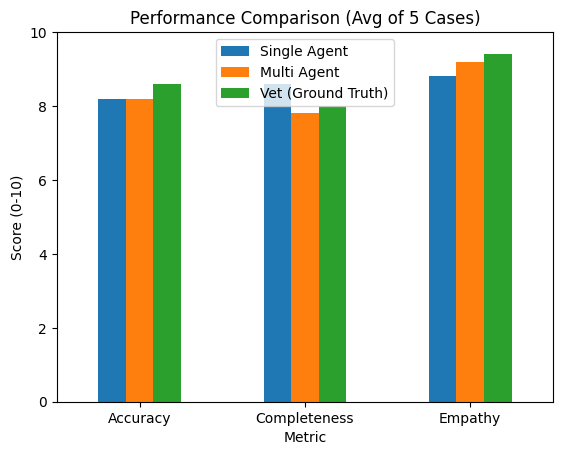

In [31]:
# 시각화
import matplotlib.pyplot as plt

if avg_single and avg_multi and avg_vet:
    df_scores = pd.DataFrame({
        'Metric': list(avg_single.keys()),
        'Single Agent': list(avg_single.values()),
        'Multi Agent': list(avg_multi.values()),
        'Vet (Ground Truth)': list(avg_vet.values())
    })

    df_scores.set_index('Metric').plot(kind='bar', ylim=(0, 10), rot=0)
    plt.title('Performance Comparison (Avg of 5 Cases)')
    plt.ylabel('Score (0-10)')
    plt.show()
